<a href="https://colab.research.google.com/github/VLCHS/FCNN/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb==0.18.7
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 15.0 MB/s eta 0:00:00


In [2]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [3]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [5]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

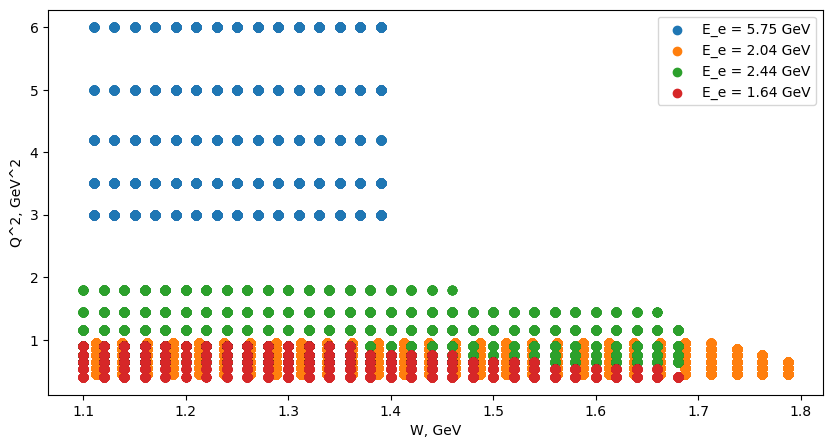

In [6]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [7]:
# Initialize wandb
run = wandb.init(project="FCNN for ep->ep_pi0, unified topology")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
class MSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,x,y):
        return self.mse(x,y)

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': False,
    'feature_scaler': StandardScaler(),   #Standard and MinMax are pretty good
    'label_scaler': StandardScaler(),
    'augment': False,
    'augment_factor': 2,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': MSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 50,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        #df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [15]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2024-12-10 19:33:40,298 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2024-12-10 19:33:40,307 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-10 19:33:40,312 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-10 19:33:40,320 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | MSELoss             | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


2024-12-10 19:33:40,573 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | MSELoss             | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
2024-12-10 19:33:40,664 : INFO : Training is starting
2024-12-10 19:34:47,849 : INFO : epoch: 0; val_loss: 7.987004280090332
2024-1

INFO: Metric val_loss improved. New best score: 7.987


2024-12-10 19:34:47,980 : INFO : Metric val_loss improved. New best score: 7.987
2024-12-10 19:34:48,319 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=7.98700-epoch=00.ckpt
2024-12-10 19:35:56,645 : INFO : epoch: 1; val_loss: 6.810347557067871
2024-12-10 19:35:56,664 : INFO : epoch: 1; train_loss: 8.239893913269043


INFO: Metric val_loss improved by 1.177 >= min_delta = 1e-05. New best score: 6.810


2024-12-10 19:35:56,754 : INFO : Metric val_loss improved by 1.177 >= min_delta = 1e-05. New best score: 6.810
2024-12-10 19:35:57,164 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=6.81035-epoch=01.ckpt
2024-12-10 19:37:17,956 : INFO : epoch: 2; val_loss: 3.4954586029052734
2024-12-10 19:37:17,971 : INFO : epoch: 2; train_loss: 5.553191661834717


INFO: Metric val_loss improved by 3.315 >= min_delta = 1e-05. New best score: 3.495


2024-12-10 19:37:18,045 : INFO : Metric val_loss improved by 3.315 >= min_delta = 1e-05. New best score: 3.495
2024-12-10 19:37:18,377 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=3.49546-epoch=02.ckpt
2024-12-10 19:38:39,847 : INFO : epoch: 3; val_loss: 5.795431613922119
2024-12-10 19:38:39,870 : INFO : epoch: 3; train_loss: 3.37235951423645
2024-12-10 19:38:40,312 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=5.79543-epoch=03.ckpt
2024-12-10 19:40:03,556 : INFO : epoch: 4; val_loss: 2.7815401554107666
2024-12-10 19:40:03,576 : INFO : epoch: 4; train_loss: 3.169250011444092


INFO: Metric val_loss improved by 0.714 >= min_delta = 1e-05. New best score: 2.782


2024-12-10 19:40:03,668 : INFO : Metric val_loss improved by 0.714 >= min_delta = 1e-05. New best score: 2.782
2024-12-10 19:40:04,174 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=2.78154-epoch=04.ckpt
2024-12-10 19:41:29,911 : INFO : epoch: 5; val_loss: 2.1634600162506104
2024-12-10 19:41:29,933 : INFO : epoch: 5; train_loss: 2.7179970741271973


INFO: Metric val_loss improved by 0.618 >= min_delta = 1e-05. New best score: 2.163


2024-12-10 19:41:30,018 : INFO : Metric val_loss improved by 0.618 >= min_delta = 1e-05. New best score: 2.163
2024-12-10 19:41:30,478 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=2.16346-epoch=05.ckpt
2024-12-10 19:42:53,486 : INFO : epoch: 6; val_loss: 2.773439407348633
2024-12-10 19:42:53,499 : INFO : epoch: 6; train_loss: 2.7991340160369873
2024-12-10 19:42:53,960 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=2.77344-epoch=06.ckpt
2024-12-10 19:44:16,731 : INFO : epoch: 7; val_loss: 1.7940101623535156
2024-12-10 19:44:16,746 : INFO : epoch: 7; train_loss: 2.5630974769592285


INFO: Metric val_loss improved by 0.369 >= min_delta = 1e-05. New best score: 1.794


2024-12-10 19:44:16,823 : INFO : Metric val_loss improved by 0.369 >= min_delta = 1e-05. New best score: 1.794
2024-12-10 19:44:17,177 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.79401-epoch=07.ckpt
2024-12-10 19:45:42,404 : INFO : epoch: 8; val_loss: 4.378592014312744
2024-12-10 19:45:42,418 : INFO : epoch: 8; train_loss: 2.513373851776123
2024-12-10 19:47:05,272 : INFO : epoch: 9; val_loss: 2.0859479904174805
2024-12-10 19:47:05,286 : INFO : epoch: 9; train_loss: 2.7232511043548584
2024-12-10 19:47:05,649 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=2.08595-epoch=09.ckpt
2024-12-10 19:48:29,260 : INFO : epoch: 10; val_loss: 14.825990676879883
2024-12-10 19:48:29,276 : INFO : epoch: 10; train_loss: 2.2519404888153076
2024-12-10 19:49:51,380 : INFO : epoch: 11; val_loss: 1.946916937828064
2024-12-10 19:49:51,393 : INF

INFO: Metric val_loss improved by 0.422 >= min_delta = 1e-05. New best score: 1.372


2024-12-10 19:52:41,359 : INFO : Metric val_loss improved by 0.422 >= min_delta = 1e-05. New best score: 1.372
2024-12-10 19:52:41,625 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.37166-epoch=13.ckpt
2024-12-10 19:54:04,427 : INFO : epoch: 14; val_loss: 1.6616941690444946
2024-12-10 19:54:04,444 : INFO : epoch: 14; train_loss: 1.8660483360290527
2024-12-10 19:54:04,813 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.66169-epoch=14.ckpt
2024-12-10 19:55:29,886 : INFO : epoch: 15; val_loss: 1.47476065158844
2024-12-10 19:55:29,902 : INFO : epoch: 15; train_loss: 1.8422614336013794
2024-12-10 19:55:30,204 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.47476-epoch=15.ckpt
2024-12-10 19:56:53,084 : INFO : epoch: 16; val_loss: 1.70197427272796

INFO: Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 1.360


2024-12-10 19:59:41,088 : INFO : Metric val_loss improved by 0.012 >= min_delta = 1e-05. New best score: 1.360
2024-12-10 19:59:41,426 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.35997-epoch=18.ckpt
2024-12-10 20:01:04,766 : INFO : epoch: 19; val_loss: 1.5700513124465942
2024-12-10 20:01:04,788 : INFO : epoch: 19; train_loss: 1.8068228960037231
2024-12-10 20:02:28,156 : INFO : epoch: 20; val_loss: 1.7933290004730225
2024-12-10 20:02:28,173 : INFO : epoch: 20; train_loss: 1.9544140100479126
2024-12-10 20:03:52,122 : INFO : epoch: 21; val_loss: 1.6549508571624756
2024-12-10 20:03:52,136 : INFO : epoch: 21; train_loss: 1.7861206531524658
2024-12-10 20:05:18,111 : INFO : epoch: 22; val_loss: 1.6282936334609985
2024-12-10 20:05:18,124 : INFO : epoch: 22; train_loss: 1.8512965440750122
2024-12-10 20:06:42,435 : INFO : epoch: 23; val_loss: 1.3116943836212158
2024-12-10 20:06:42,452 : INFO : epoch: 23; train

INFO: Metric val_loss improved by 0.048 >= min_delta = 1e-05. New best score: 1.312


2024-12-10 20:06:42,517 : INFO : Metric val_loss improved by 0.048 >= min_delta = 1e-05. New best score: 1.312
2024-12-10 20:06:42,694 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.31169-epoch=23.ckpt
2024-12-10 20:08:07,362 : INFO : epoch: 24; val_loss: 1.757193684577942
2024-12-10 20:08:07,375 : INFO : epoch: 24; train_loss: 1.7501847743988037
2024-12-10 20:09:34,016 : INFO : epoch: 25; val_loss: 1.7714182138442993
2024-12-10 20:09:34,030 : INFO : epoch: 25; train_loss: 1.8887723684310913
2024-12-10 20:10:57,586 : INFO : epoch: 26; val_loss: 1.4568690061569214
2024-12-10 20:10:57,600 : INFO : epoch: 26; train_loss: 1.777157187461853
2024-12-10 20:12:21,506 : INFO : epoch: 27; val_loss: 1.3258335590362549
2024-12-10 20:12:21,520 : INFO : epoch: 27; train_loss: 1.7444608211517334
2024-12-10 20:12:21,712 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/ch

INFO: Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 1.214


2024-12-10 20:16:37,052 : INFO : Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 1.214
2024-12-10 20:16:37,242 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.21369-epoch=30.ckpt
2024-12-10 20:18:03,121 : INFO : epoch: 31; val_loss: 1.6145646572113037
2024-12-10 20:18:03,137 : INFO : epoch: 31; train_loss: 1.5827693939208984
2024-12-10 20:19:26,491 : INFO : epoch: 32; val_loss: 1.5413204431533813
2024-12-10 20:19:26,506 : INFO : epoch: 32; train_loss: 1.5901288986206055
2024-12-10 20:20:50,400 : INFO : epoch: 33; val_loss: 1.441948652267456
2024-12-10 20:20:50,418 : INFO : epoch: 33; train_loss: 1.623063325881958
2024-12-10 20:22:15,400 : INFO : epoch: 34; val_loss: 1.281799077987671
2024-12-10 20:22:15,418 : INFO : epoch: 34; train_loss: 1.6411361694335938
2024-12-10 20:22:15,739 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/che

INFO: Metric val_loss improved by 0.026 >= min_delta = 1e-05. New best score: 1.188


2024-12-10 20:39:41,194 : INFO : Metric val_loss improved by 0.026 >= min_delta = 1e-05. New best score: 1.188
2024-12-10 20:39:41,461 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.18763-epoch=46.ckpt
2024-12-10 20:41:09,814 : INFO : epoch: 47; val_loss: 1.1826225519180298
2024-12-10 20:41:09,830 : INFO : epoch: 47; train_loss: 1.491217017173767


INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.183


2024-12-10 20:41:09,921 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.183
2024-12-10 20:41:10,238 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.18262-epoch=47.ckpt
2024-12-10 20:42:35,379 : INFO : epoch: 48; val_loss: 1.2404847145080566
2024-12-10 20:42:35,395 : INFO : epoch: 48; train_loss: 1.475116491317749
2024-12-10 20:44:00,135 : INFO : epoch: 49; val_loss: 1.1399403810501099
2024-12-10 20:44:00,147 : INFO : epoch: 49; train_loss: 1.4965779781341553


INFO: Metric val_loss improved by 0.043 >= min_delta = 1e-05. New best score: 1.140


2024-12-10 20:44:00,207 : INFO : Metric val_loss improved by 0.043 >= min_delta = 1e-05. New best score: 1.140
2024-12-10 20:44:00,379 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.13994-epoch=49.ckpt
2024-12-10 20:45:27,259 : INFO : epoch: 50; val_loss: 1.2184967994689941
2024-12-10 20:45:27,279 : INFO : epoch: 50; train_loss: 1.4900329113006592
2024-12-10 20:46:53,113 : INFO : epoch: 51; val_loss: 1.1633920669555664
2024-12-10 20:46:53,130 : INFO : epoch: 51; train_loss: 1.4740070104599
2024-12-10 20:46:53,342 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.16339-epoch=51.ckpt
2024-12-10 20:48:17,803 : INFO : epoch: 52; val_loss: 1.1724977493286133
2024-12-10 20:48:17,819 : INFO : epoch: 52; train_loss: 1.5006121397018433
2024-12-10 20:48:18,171 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unifie

INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.135


2024-12-10 21:06:47,384 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.135
2024-12-10 21:06:47,597 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.13504-epoch=65.ckpt
2024-12-10 21:08:13,294 : INFO : epoch: 66; val_loss: 1.219849944114685
2024-12-10 21:08:13,310 : INFO : epoch: 66; train_loss: 1.4692354202270508
2024-12-10 21:09:37,934 : INFO : epoch: 67; val_loss: 1.1390821933746338
2024-12-10 21:09:37,948 : INFO : epoch: 67; train_loss: 1.4181909561157227
2024-12-10 21:09:38,192 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.13908-epoch=67.ckpt
2024-12-10 21:11:05,692 : INFO : epoch: 68; val_loss: 1.1903185844421387
2024-12-10 21:11:05,707 : INFO : epoch: 68; train_loss: 1.419740080833435
2024-12-10 21:12:30,907 : INFO : epoch: 69; val_loss: 1.149694561958313
2024-12-10 21:12:30,920 :

INFO: Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 1.126


2024-12-10 21:16:50,217 : INFO : Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 1.126
2024-12-10 21:16:50,517 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.12619-epoch=72.ckpt
2024-12-10 21:18:17,995 : INFO : epoch: 73; val_loss: 1.1882294416427612
2024-12-10 21:18:18,009 : INFO : epoch: 73; train_loss: 1.4032145738601685
2024-12-10 21:19:43,644 : INFO : epoch: 74; val_loss: 1.225098729133606
2024-12-10 21:19:43,658 : INFO : epoch: 74; train_loss: 1.411290168762207
2024-12-10 21:21:09,943 : INFO : epoch: 75; val_loss: 1.129520058631897
2024-12-10 21:21:09,961 : INFO : epoch: 75; train_loss: 1.4105406999588013
2024-12-10 21:21:10,333 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.12952-epoch=75.ckpt
2024-12-10 21:22:40,388 : INFO : epoch: 76; val_loss: 1.1723806858062744
2024-12-10 21:22:40,403 :

INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 1.122


2024-12-10 21:31:20,356 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 1.122
2024-12-10 21:31:20,626 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.12185-epoch=82.ckpt
2024-12-10 21:32:48,210 : INFO : epoch: 83; val_loss: 1.1382914781570435
2024-12-10 21:32:48,224 : INFO : epoch: 83; train_loss: 1.3654093742370605
2024-12-10 21:34:17,983 : INFO : epoch: 84; val_loss: 1.133533239364624
2024-12-10 21:34:17,997 : INFO : epoch: 84; train_loss: 1.3661450147628784
2024-12-10 21:35:43,879 : INFO : epoch: 85; val_loss: 1.1199485063552856
2024-12-10 21:35:43,892 : INFO : epoch: 85; train_loss: 1.360438346862793


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.120


2024-12-10 21:35:43,954 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.120
2024-12-10 21:35:44,164 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.11995-epoch=85.ckpt
2024-12-10 21:37:11,409 : INFO : epoch: 86; val_loss: 1.1177245378494263
2024-12-10 21:37:11,426 : INFO : epoch: 86; train_loss: 1.3616114854812622


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.118


2024-12-10 21:37:11,514 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.118
2024-12-10 21:37:11,822 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.11772-epoch=86.ckpt
2024-12-10 21:38:40,741 : INFO : epoch: 87; val_loss: 1.1298470497131348
2024-12-10 21:38:40,753 : INFO : epoch: 87; train_loss: 1.3609988689422607
2024-12-10 21:40:08,261 : INFO : epoch: 88; val_loss: 1.1232590675354004
2024-12-10 21:40:08,282 : INFO : epoch: 88; train_loss: 1.3785406351089478
2024-12-10 21:41:36,289 : INFO : epoch: 89; val_loss: 1.138164758682251
2024-12-10 21:41:36,305 : INFO : epoch: 89; train_loss: 1.367845892906189
2024-12-10 21:43:05,627 : INFO : epoch: 90; val_loss: 1.1225214004516602
2024-12-10 21:43:05,640 : INFO : epoch: 90; train_loss: 1.3588171005249023
2024-12-10 21:44:32,953 : INFO : epoch: 91; val_loss: 1.1095644235610962
2024-12-10 21:44:32,968 : INFO : epoch: 91; train_l

INFO: Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 1.110


2024-12-10 21:44:33,048 : INFO : Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 1.110
2024-12-10 21:44:33,292 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10956-epoch=91.ckpt
2024-12-10 21:46:04,675 : INFO : epoch: 92; val_loss: 1.1356234550476074
2024-12-10 21:46:04,691 : INFO : epoch: 92; train_loss: 1.3611537218093872
2024-12-10 21:47:32,262 : INFO : epoch: 93; val_loss: 1.1549875736236572
2024-12-10 21:47:32,275 : INFO : epoch: 93; train_loss: 1.3608322143554688
2024-12-10 21:49:00,202 : INFO : epoch: 94; val_loss: 1.1296722888946533
2024-12-10 21:49:00,217 : INFO : epoch: 94; train_loss: 1.356654405593872
2024-12-10 21:50:32,399 : INFO : epoch: 95; val_loss: 1.1127536296844482
2024-12-10 21:50:32,413 : INFO : epoch: 95; train_loss: 1.3528242111206055
2024-12-10 21:50:32,680 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/c

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.108


2024-12-10 22:08:48,918 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.108
2024-12-10 22:08:49,214 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10824-epoch=107.ckpt
2024-12-10 22:10:22,450 : INFO : epoch: 108; val_loss: 1.1211223602294922
2024-12-10 22:10:22,463 : INFO : epoch: 108; train_loss: 1.3363845348358154
2024-12-10 22:11:55,194 : INFO : epoch: 109; val_loss: 1.1092166900634766
2024-12-10 22:11:55,209 : INFO : epoch: 109; train_loss: 1.347211480140686
2024-12-10 22:11:55,456 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10922-epoch=109.ckpt
2024-12-10 22:13:29,562 : INFO : epoch: 110; val_loss: 1.1296300888061523
2024-12-10 22:13:29,582 : INFO : epoch: 110; train_loss: 1.339365839958191
2024-12-10 22:15:03,738 : INFO : epoch: 111; val_loss: 1.1238384246826172
2024-12-10 22:1

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.108


2024-12-10 22:32:39,918 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.108
2024-12-10 22:32:40,102 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10763-epoch=122.ckpt
2024-12-10 22:34:19,319 : INFO : epoch: 123; val_loss: 1.1087695360183716
2024-12-10 22:34:19,332 : INFO : epoch: 123; train_loss: 1.3270466327667236
2024-12-10 22:35:56,077 : INFO : epoch: 124; val_loss: 1.1134488582611084
2024-12-10 22:35:56,091 : INFO : epoch: 124; train_loss: 1.325840711593628
2024-12-10 22:37:34,869 : INFO : epoch: 125; val_loss: 1.119957685470581
2024-12-10 22:37:34,884 : INFO : epoch: 125; train_loss: 1.3225356340408325
2024-12-10 22:39:12,511 : INFO : epoch: 126; val_loss: 1.1131340265274048
2024-12-10 22:39:12,526 : INFO : epoch: 126; train_loss: 1.3212316036224365
2024-12-10 22:40:52,964 : INFO : epoch: 127; val_loss: 1.1124967336654663
2024-12-10 22:40:52,978 : INFO : epoch: 1

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.108


2024-12-10 22:45:51,299 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.108
2024-12-10 22:45:51,475 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10752-epoch=130.ckpt
2024-12-10 22:47:30,130 : INFO : epoch: 131; val_loss: 1.1070154905319214
2024-12-10 22:47:30,143 : INFO : epoch: 131; train_loss: 1.3224157094955444


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.107


2024-12-10 22:47:30,207 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.107
2024-12-10 22:47:30,398 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10702-epoch=131.ckpt
2024-12-10 22:49:11,188 : INFO : epoch: 132; val_loss: 1.1091424226760864
2024-12-10 22:49:11,201 : INFO : epoch: 132; train_loss: 1.3229268789291382
2024-12-10 22:50:50,269 : INFO : epoch: 133; val_loss: 1.1081026792526245
2024-12-10 22:50:50,286 : INFO : epoch: 133; train_loss: 1.3164902925491333
2024-12-10 22:52:32,662 : INFO : epoch: 134; val_loss: 1.1127375364303589
2024-12-10 22:52:32,678 : INFO : epoch: 134; train_loss: 1.3194454908370972
2024-12-10 22:54:12,252 : INFO : epoch: 135; val_loss: 1.1095612049102783
2024-12-10 22:54:12,267 : INFO : epoch: 135; train_loss: 1.3169455528259277
2024-12-10 22:55:54,605 : INFO : epoch: 136; val_loss: 1.1114943027496338
2024-12-10 22:55:54,618 : INFO : epoch:

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.106


2024-12-10 23:14:49,071 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.106
2024-12-10 23:14:49,275 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/royal-sun-15/checkpoints/exp_name=0val_loss=1.10571-epoch=147.ckpt
2024-12-10 23:16:35,253 : INFO : epoch: 148; val_loss: 1.1121046543121338
2024-12-10 23:16:35,269 : INFO : epoch: 148; train_loss: 1.313812255859375
2024-12-10 23:18:22,320 : INFO : epoch: 149; val_loss: 1.1106512546539307
2024-12-10 23:18:22,333 : INFO : epoch: 149; train_loss: 1.316743016242981
2024-12-10 23:20:04,963 : INFO : epoch: 150; val_loss: 1.1091548204421997
2024-12-10 23:20:04,978 : INFO : epoch: 150; train_loss: 1.3122270107269287
2024-12-10 23:21:50,199 : INFO : epoch: 151; val_loss: 1.1082298755645752
2024-12-10 23:21:50,216 : INFO : epoch: 151; train_loss: 1.3124830722808838
2024-12-10 23:23:34,754 : INFO : epoch: 152; val_loss: 1.109866738319397
2024-12-10 23:23:34,770 : INFO : epoch: 15

INFO: Monitored metric val_loss did not improve in the last 50 records. Best score: 1.106. Signaling Trainer to stop.


2024-12-11 00:46:46,705 : INFO : Monitored metric val_loss did not improve in the last 50 records. Best score: 1.106. Signaling Trainer to stop.
2024-12-11 00:46:46,715 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [16]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [17]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:06<00:00, 24.86it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-16-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15355763152619142' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-16-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01106379976831363' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2024-12-11 00:58:46,515 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-11 00:58:46,520 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2024-12-11 00:58:46,526 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-11 00:58:46,530 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-11 00:58:46,534 : DEBUG : findfont: score(FontEntry(f

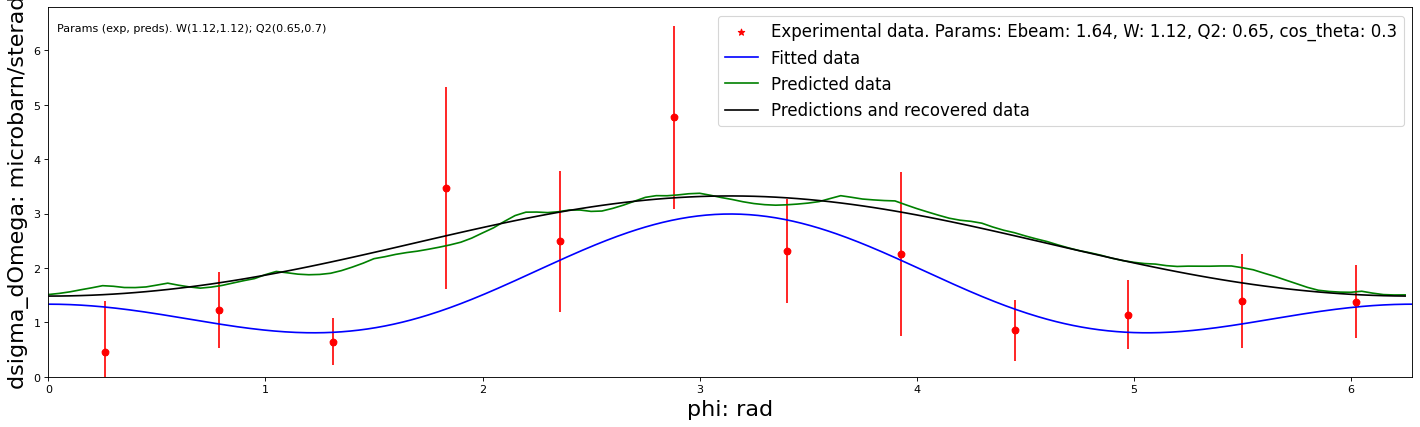

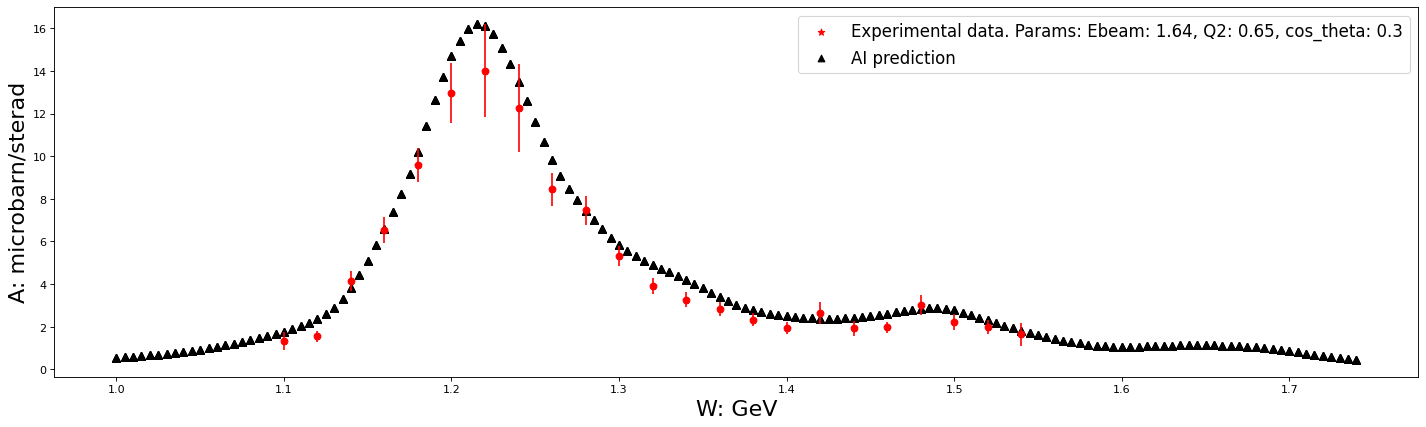

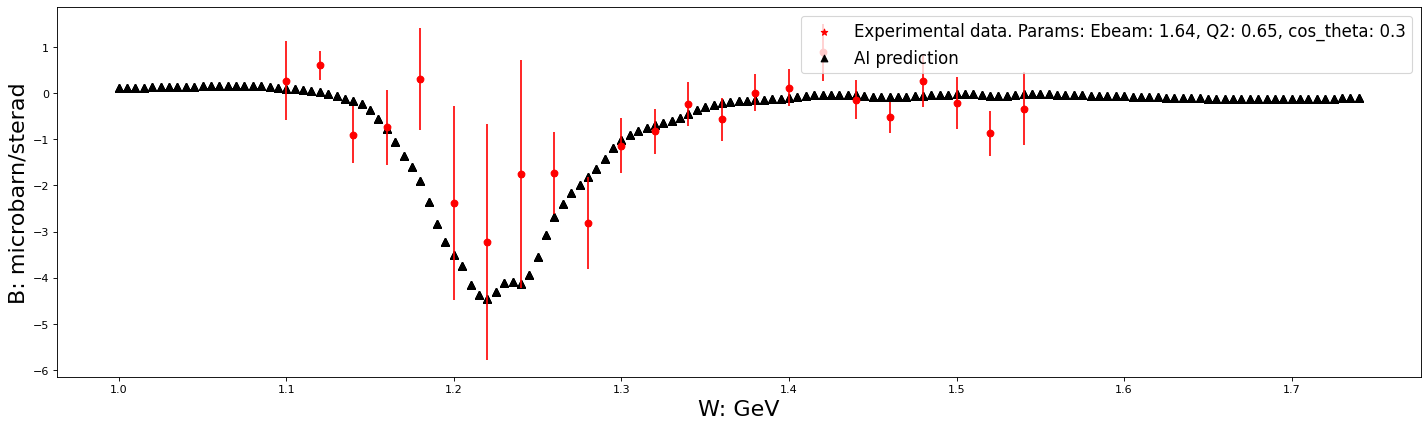

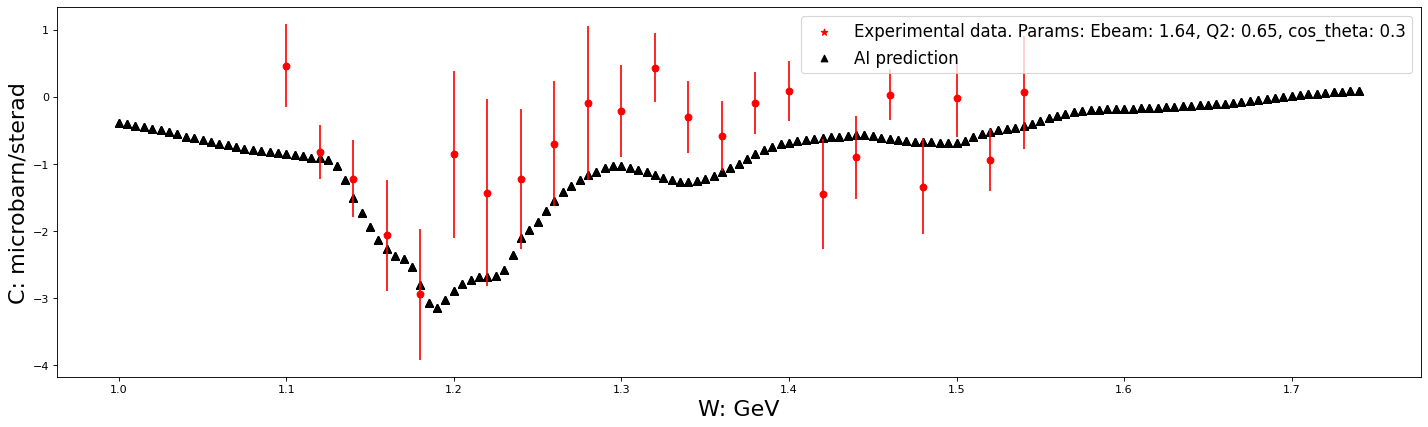

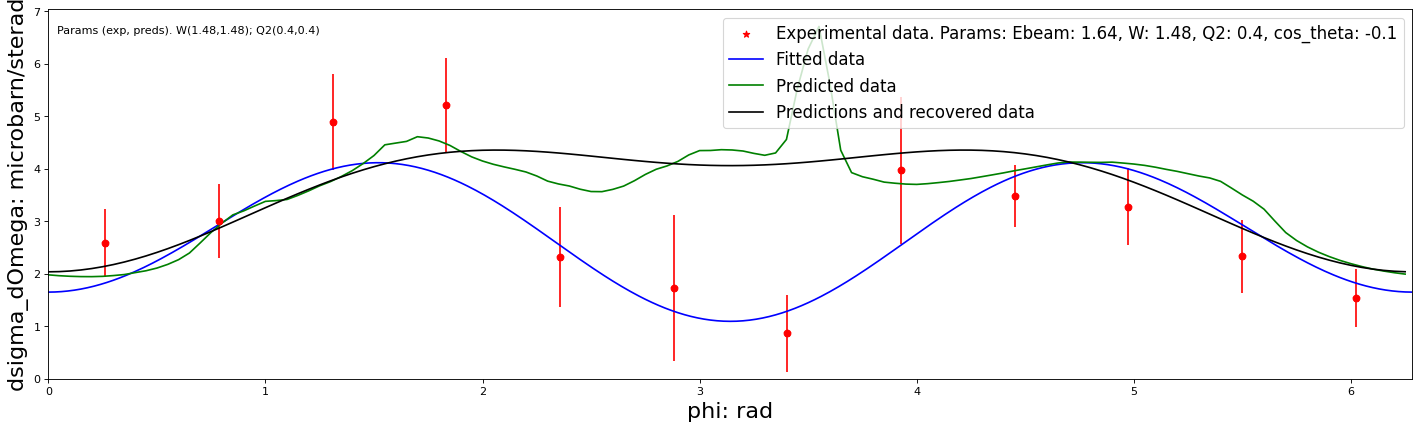

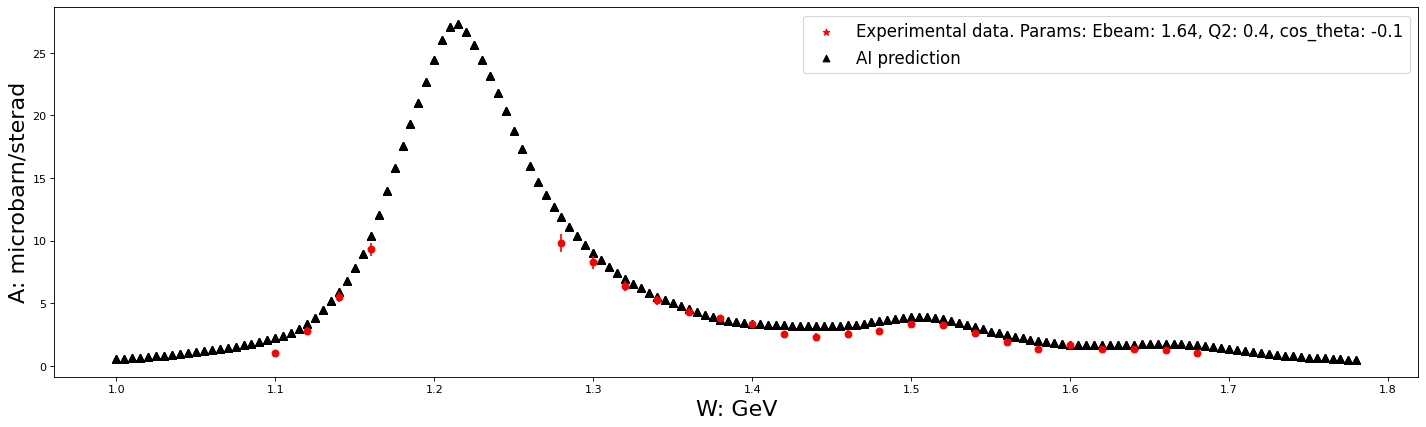

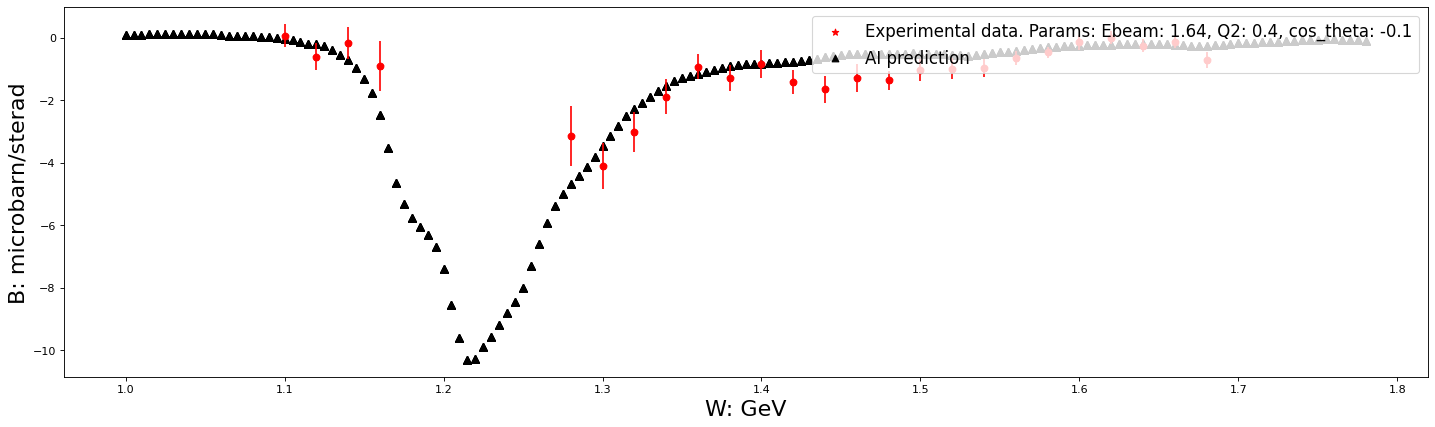

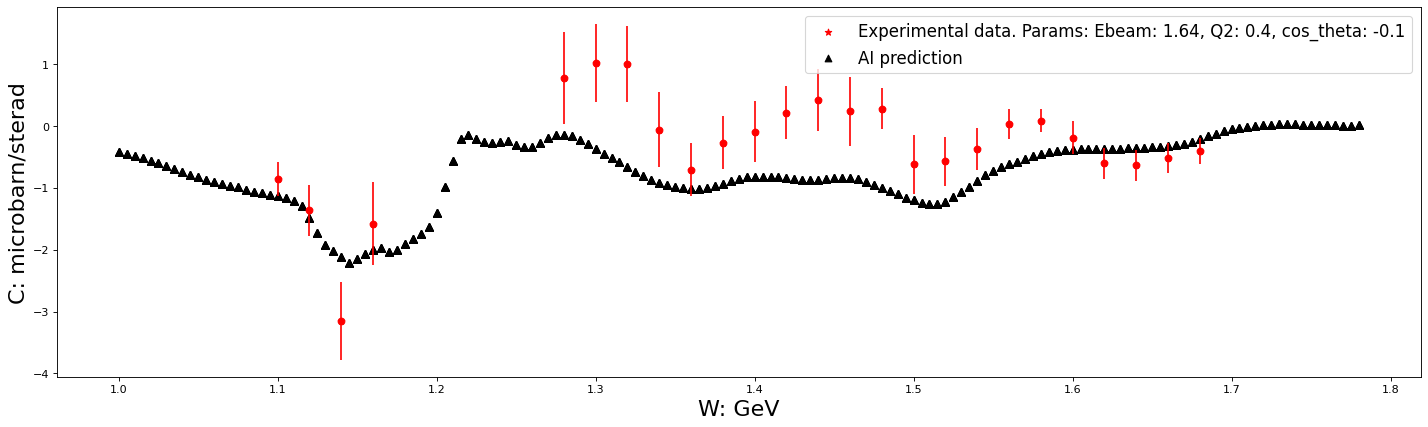

100%|██████████| 157/157 [00:07<00:00, 20.96it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-16-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21164805839406522' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-16-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0005149556447792169' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-

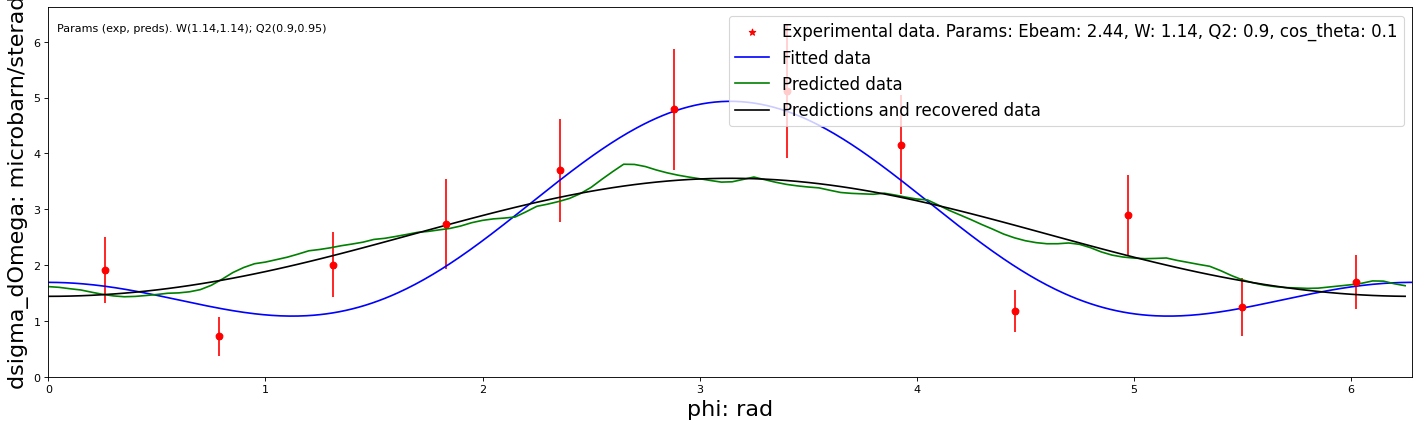

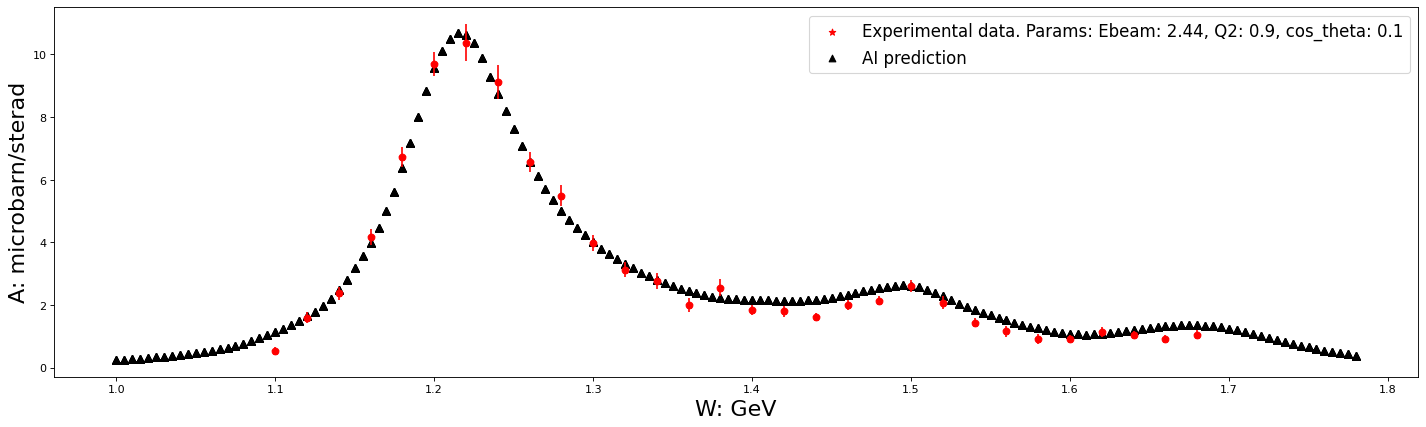

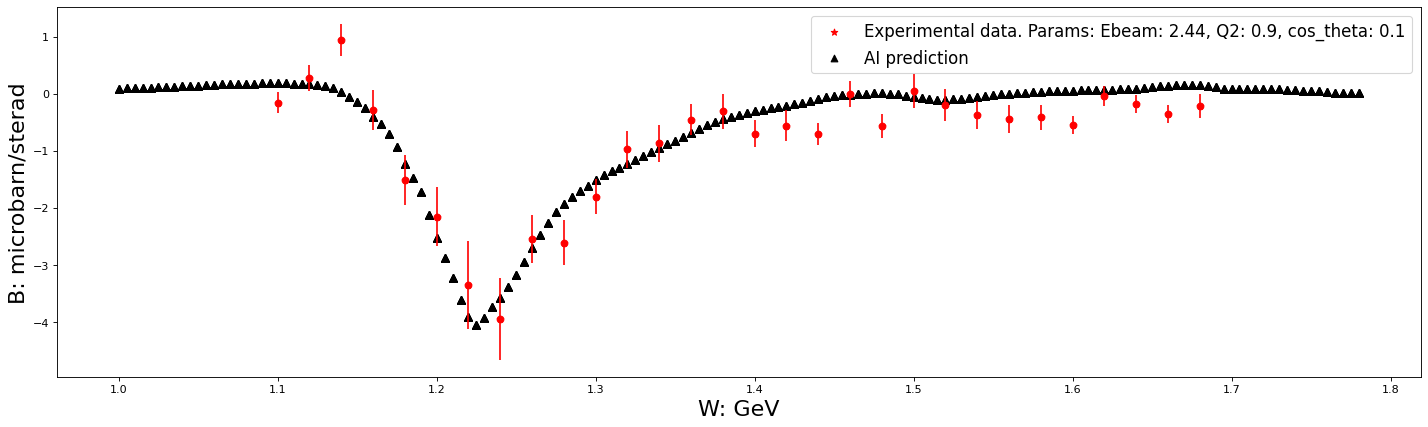

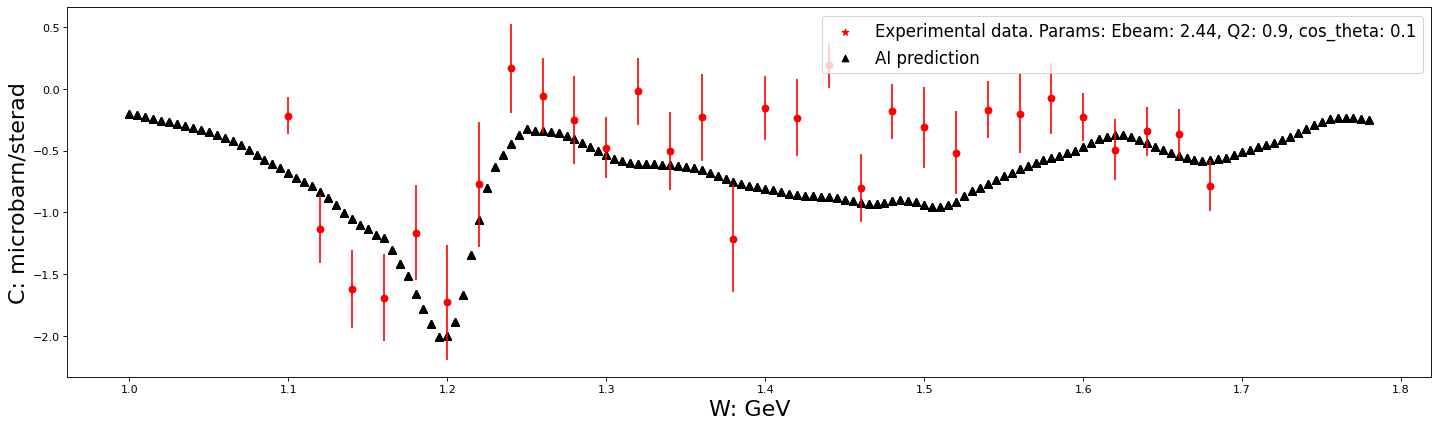

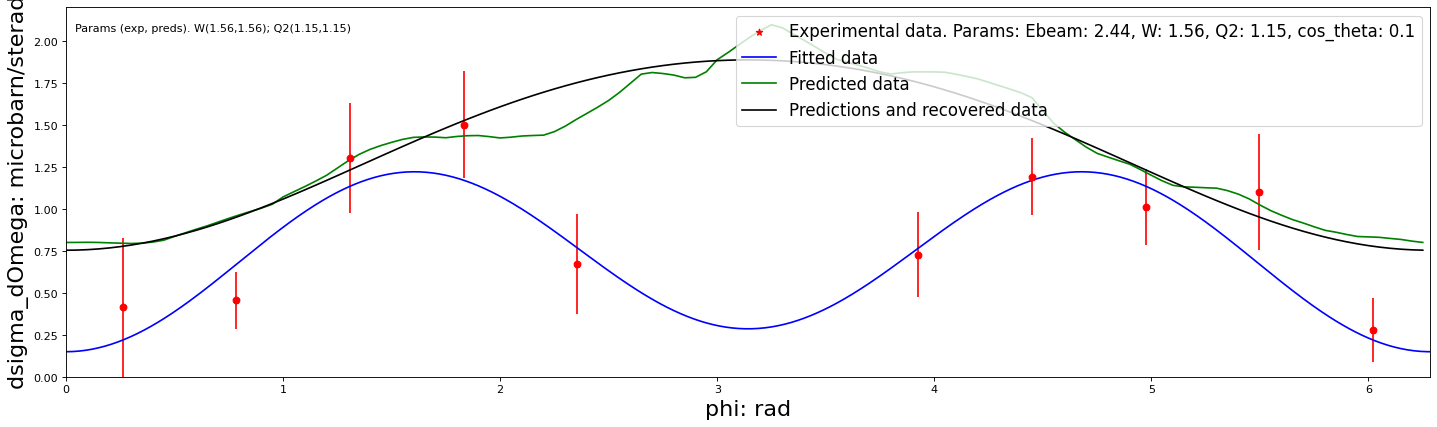

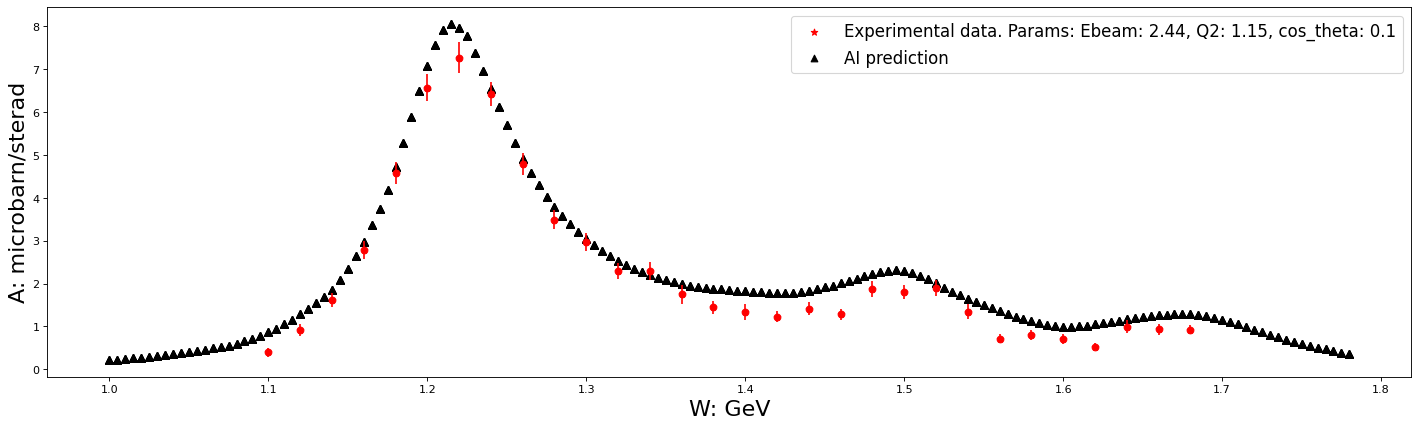

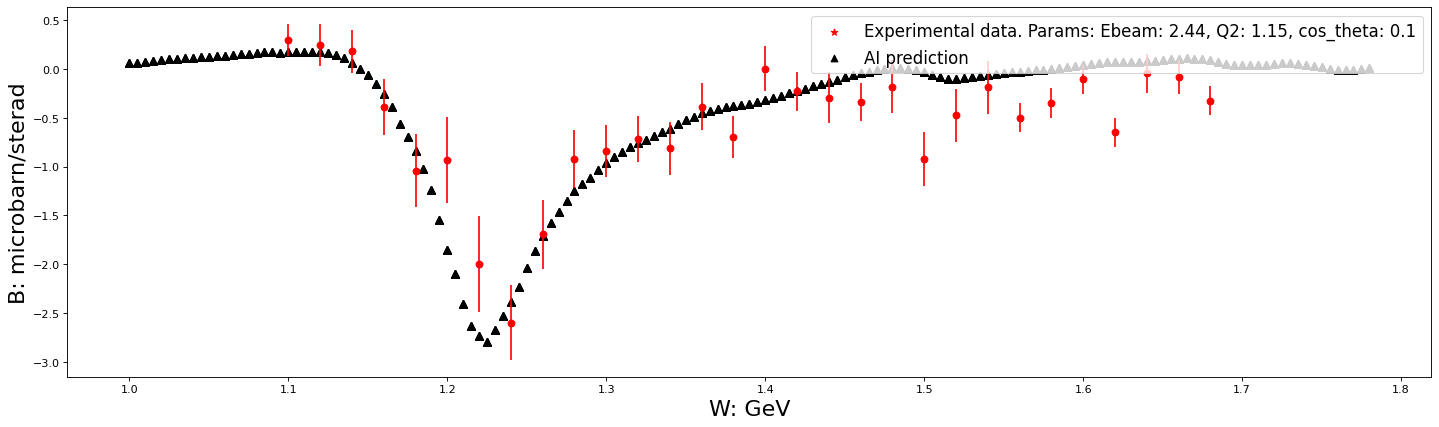

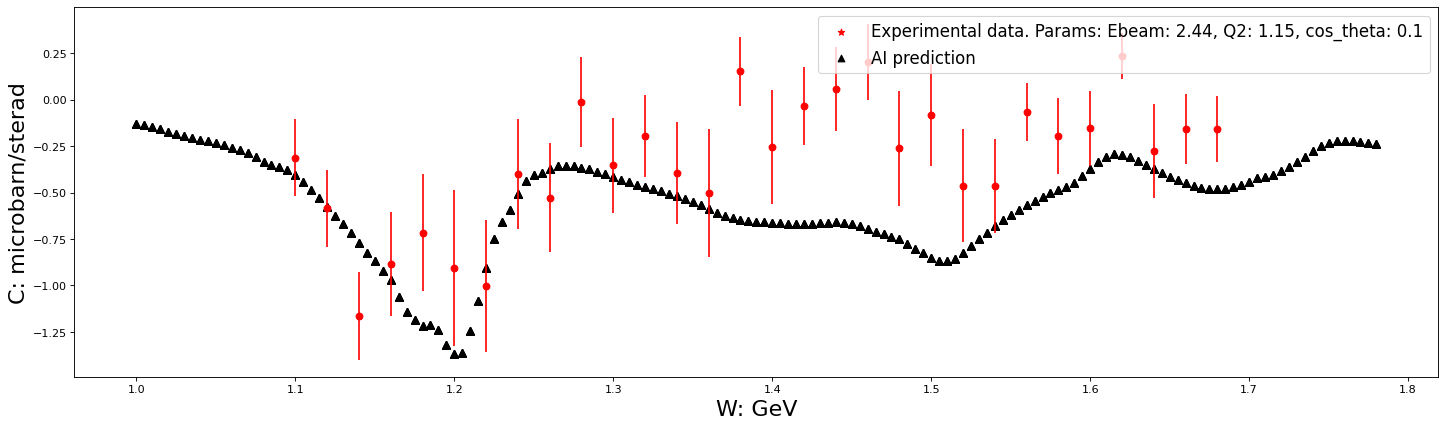

100%|██████████| 97/97 [00:08<00:00, 11.02it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-16-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.062210975644030164' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-16-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.005051239378761603' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

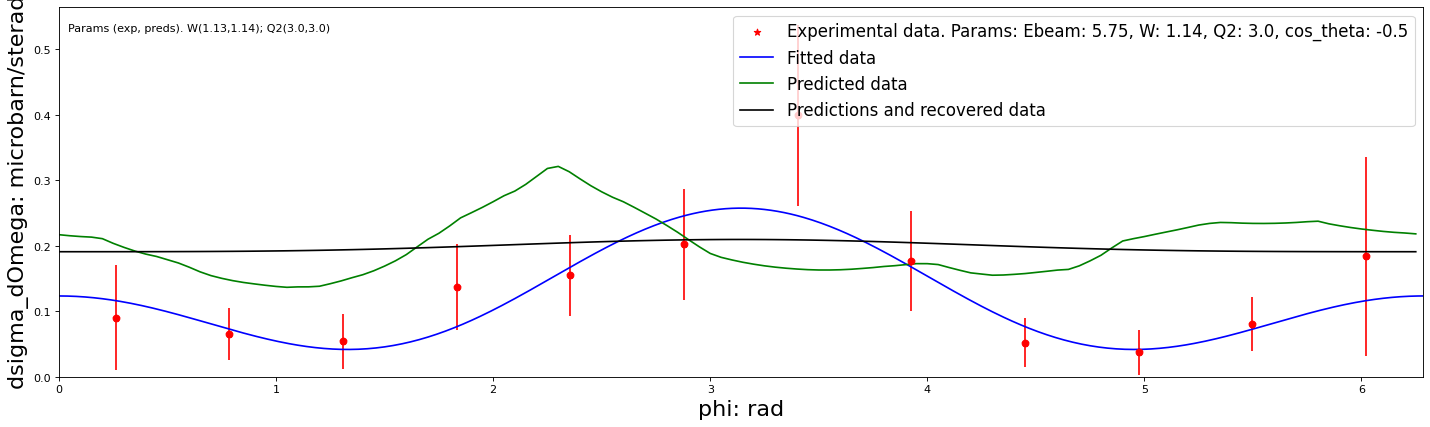

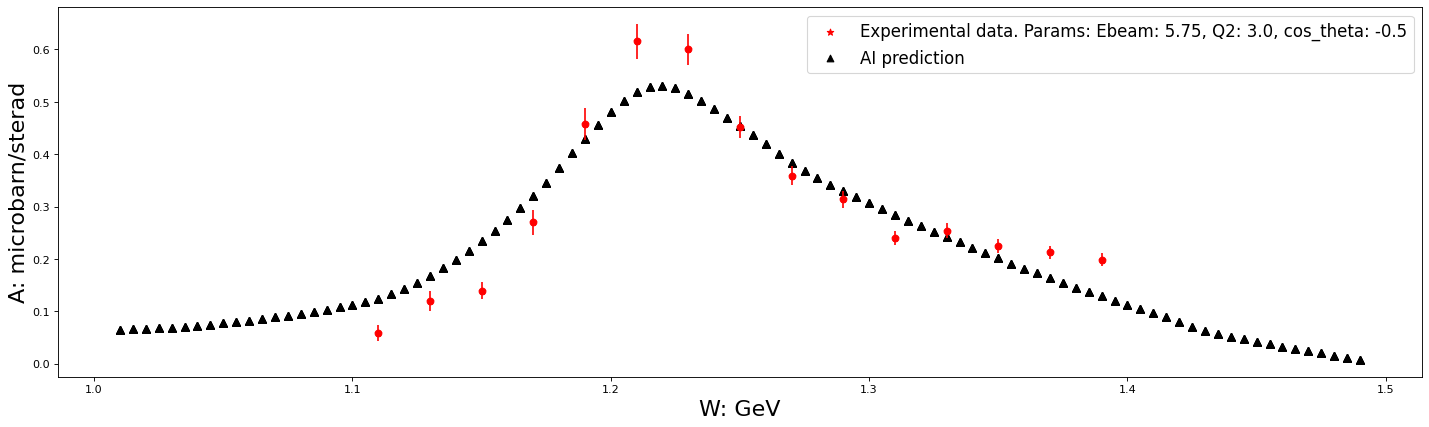

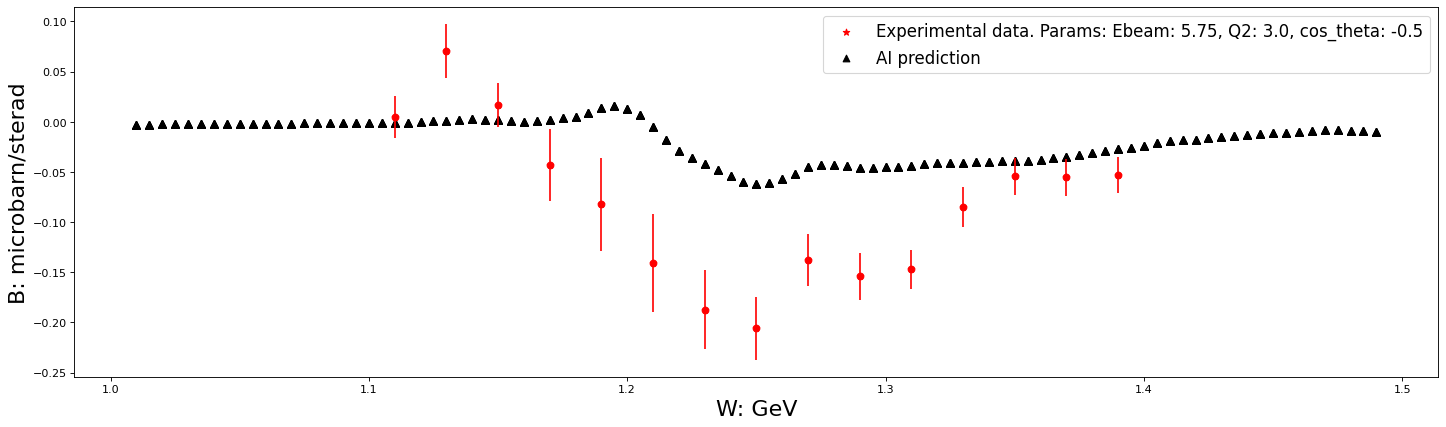

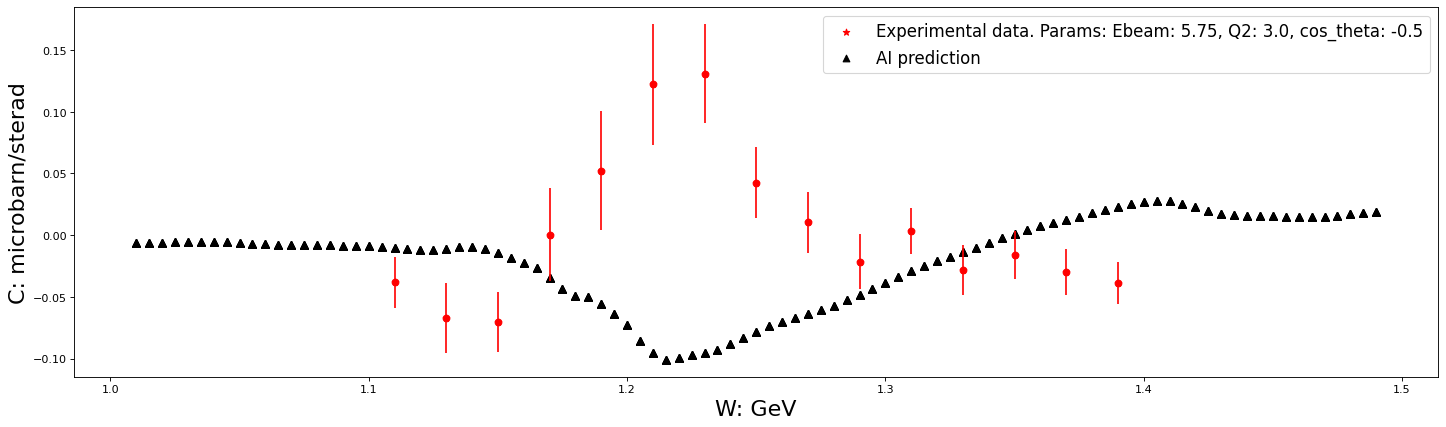

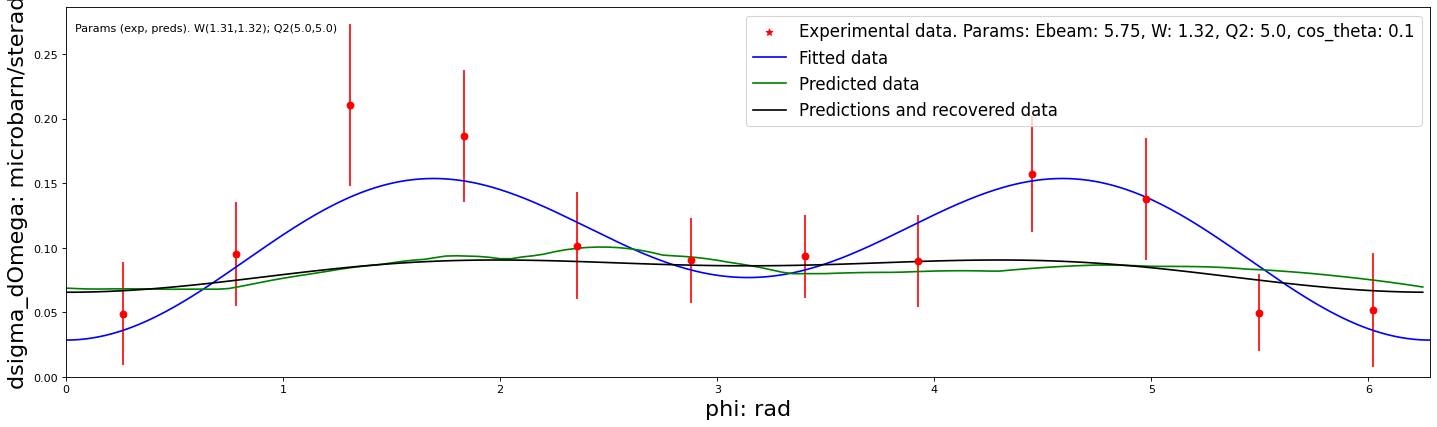

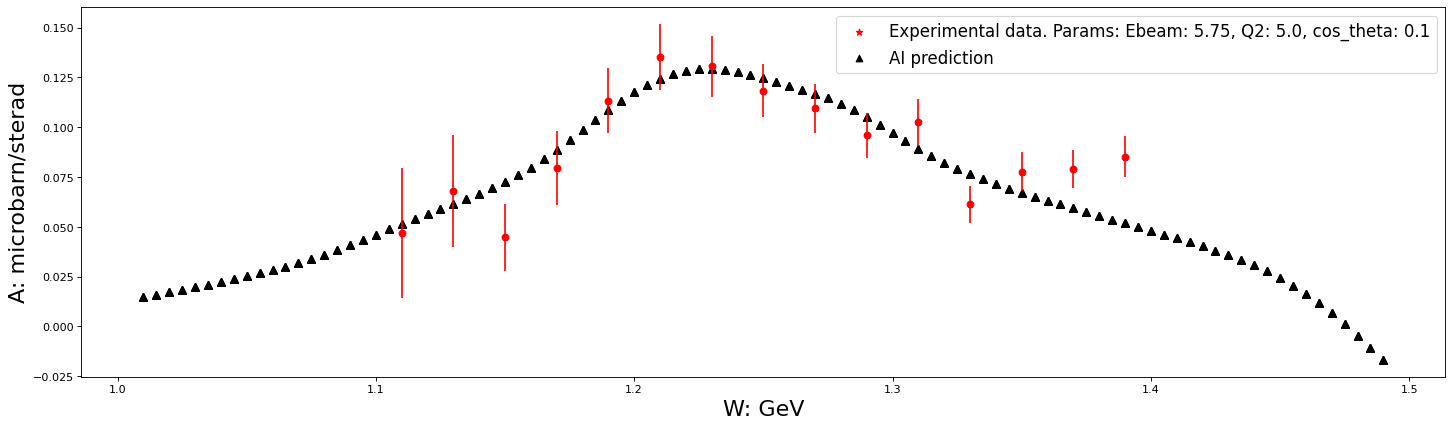

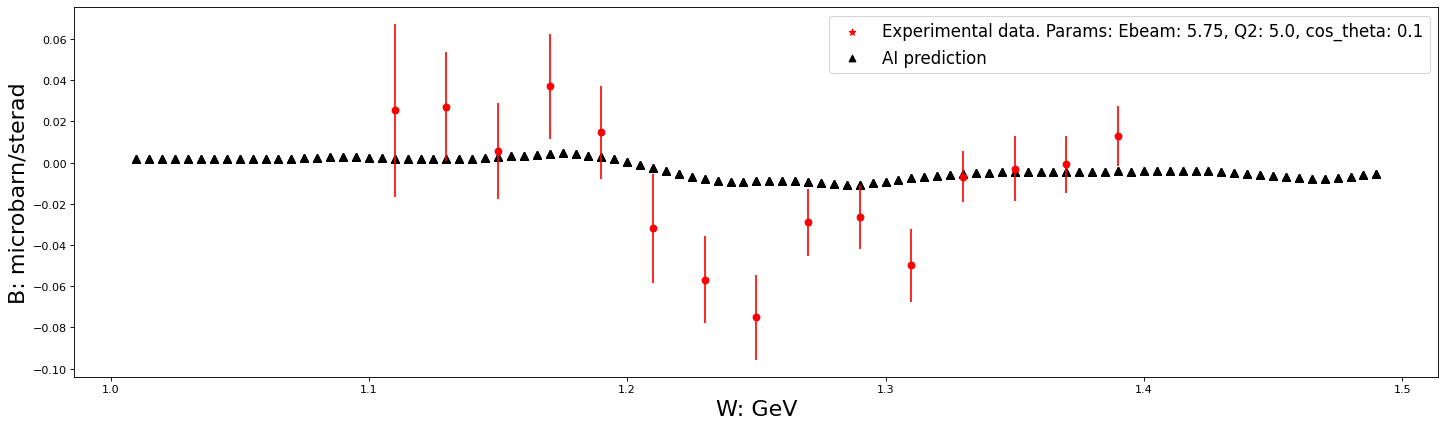

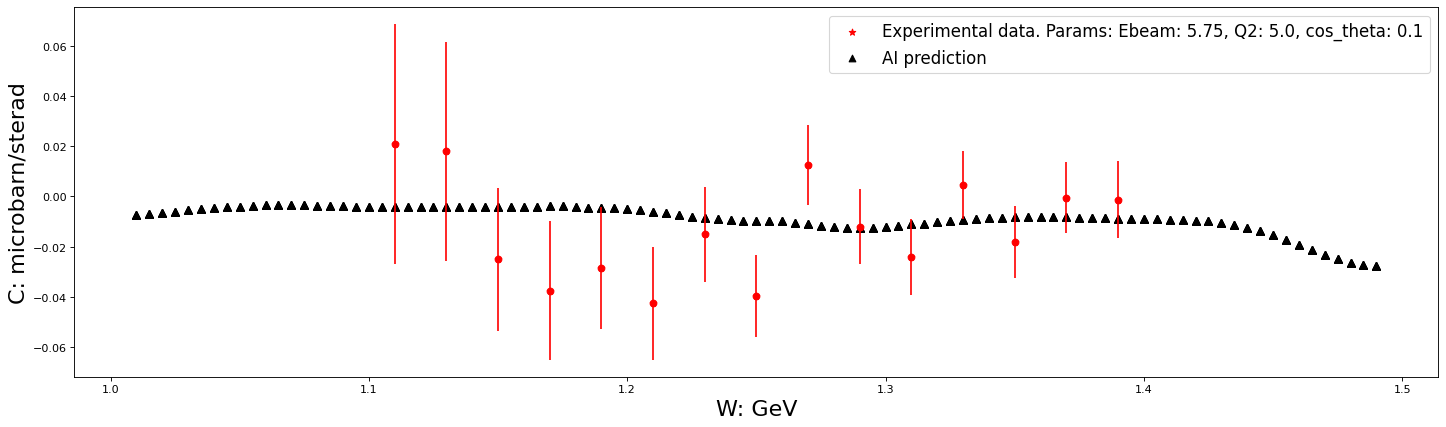

100%|██████████| 177/177 [00:05<00:00, 35.23it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-16-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13453035615483763' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-16-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.002671771707729676' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

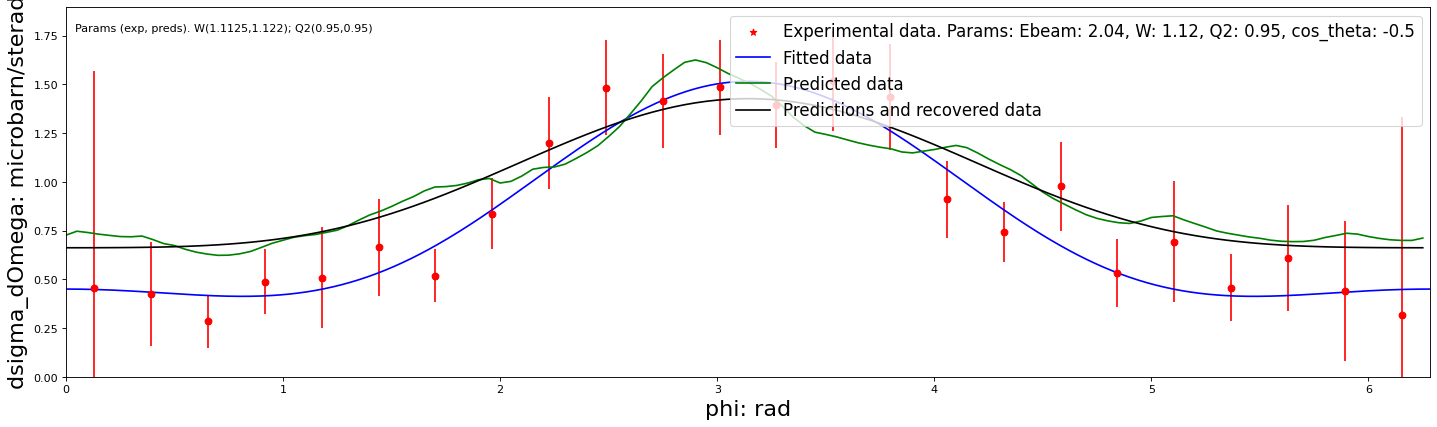

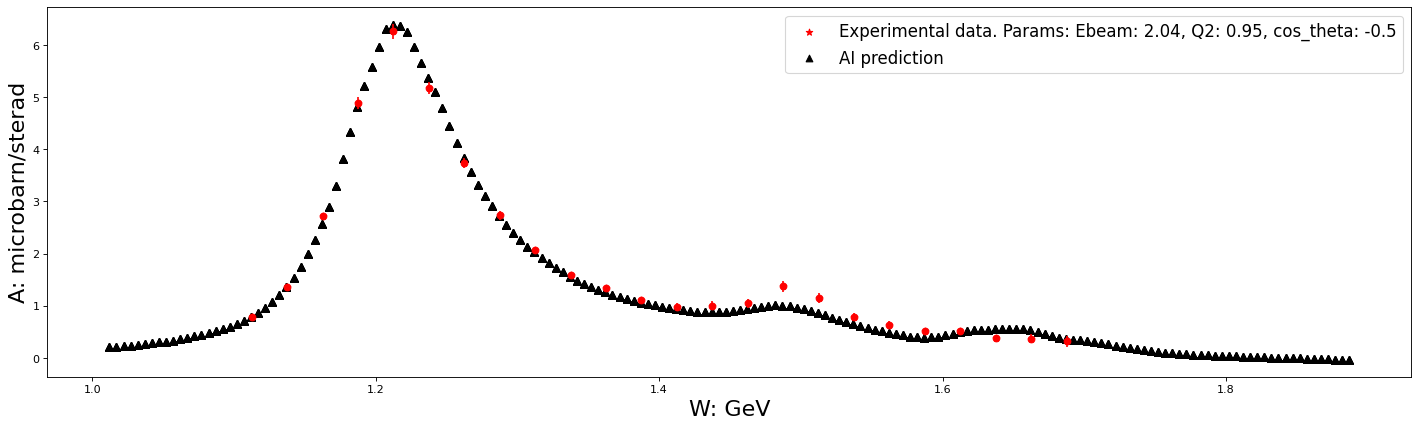

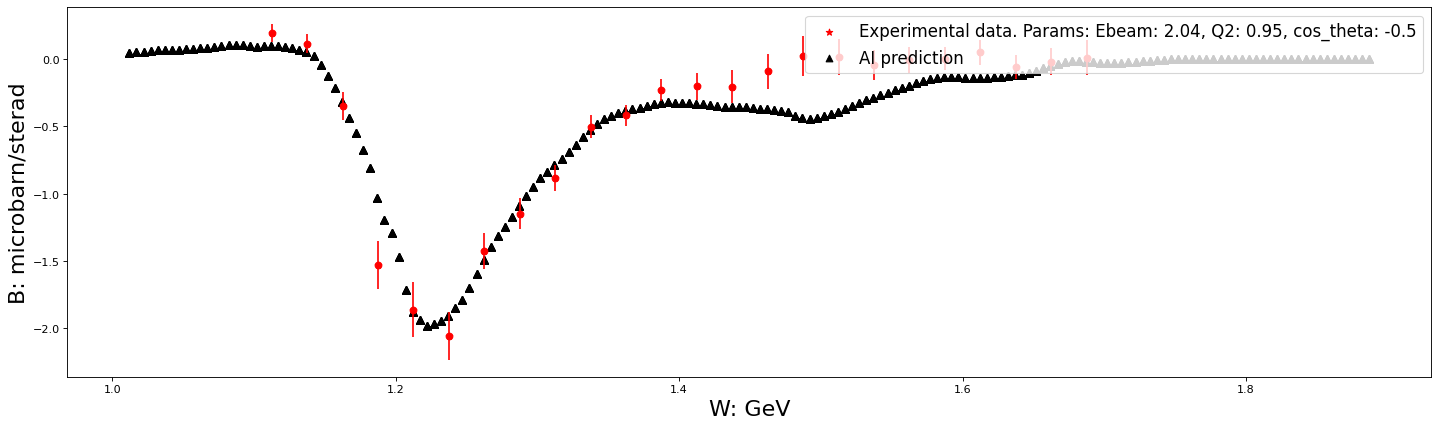

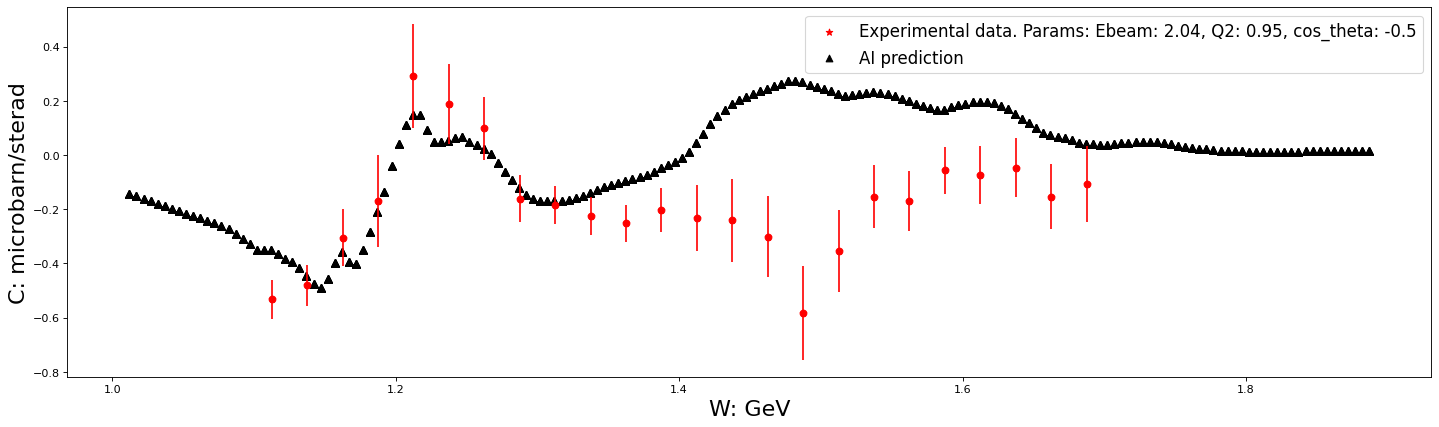

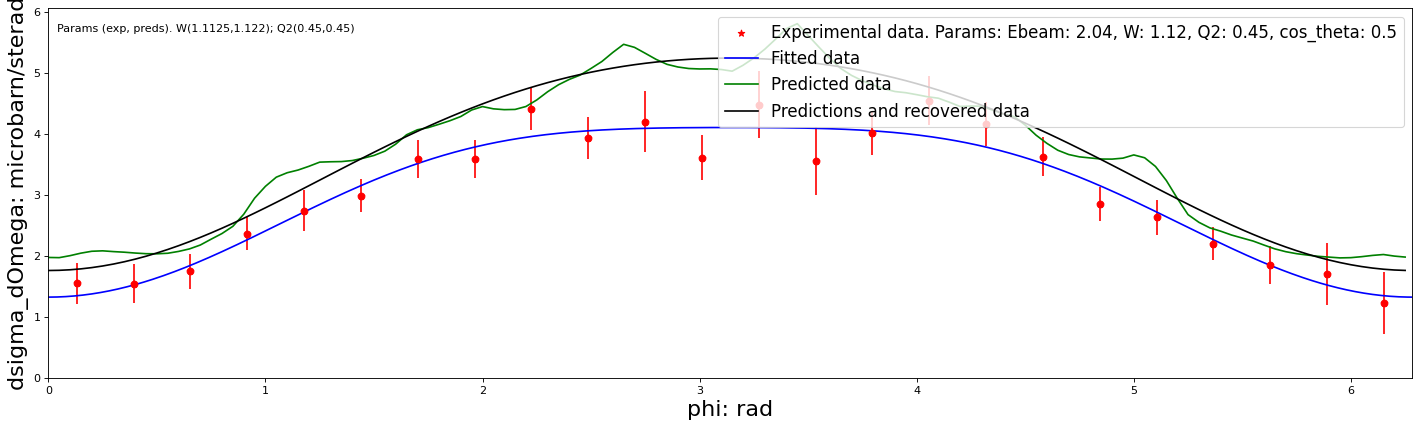

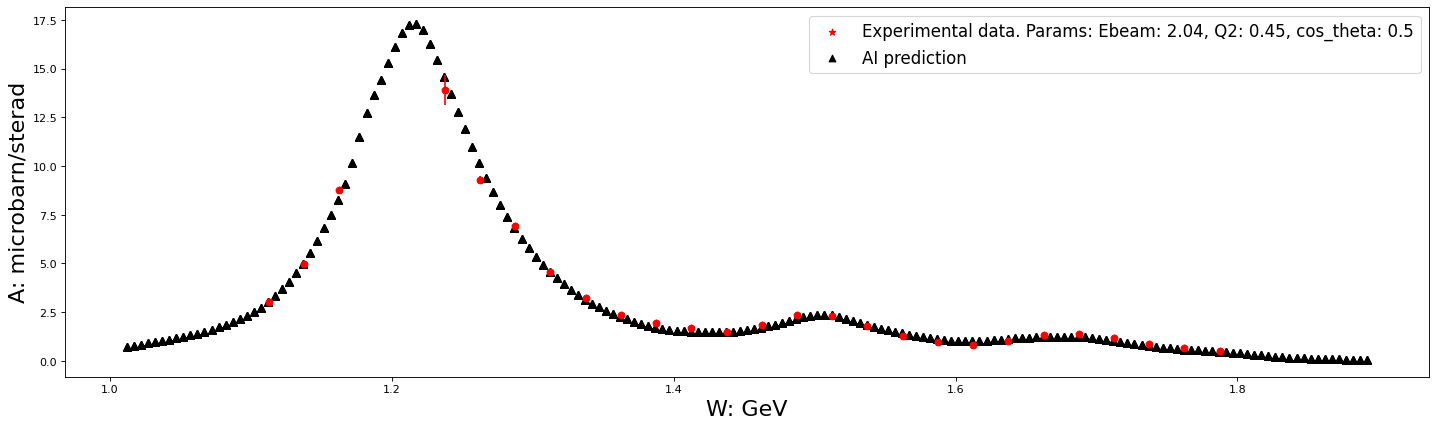

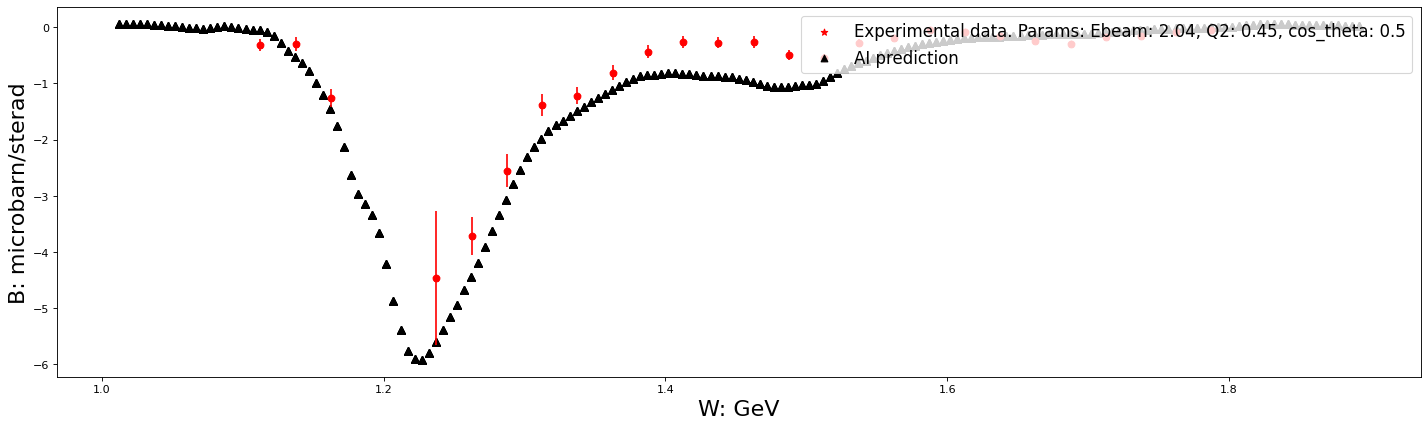

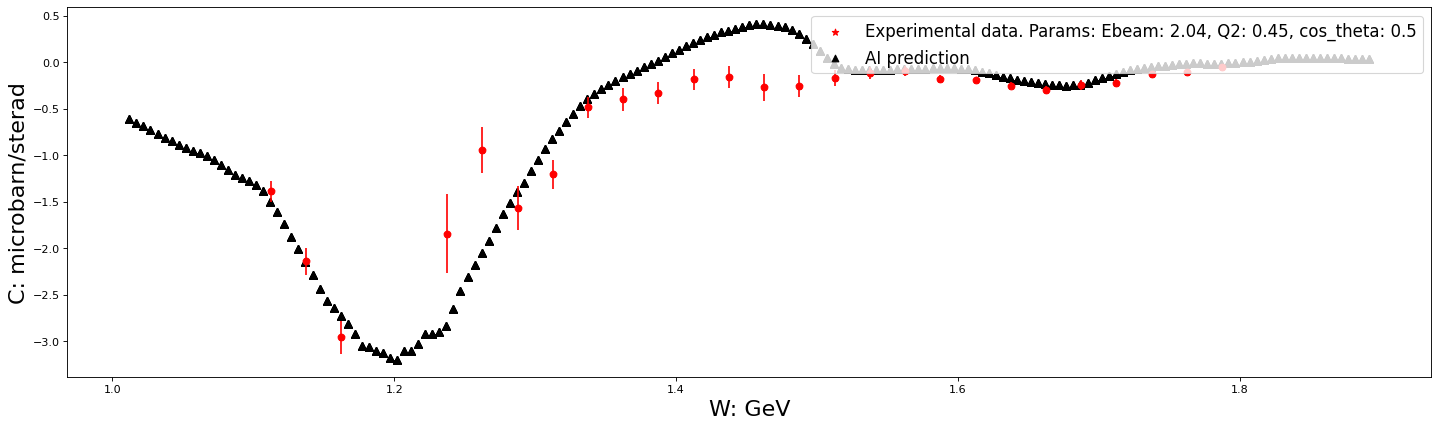

In [18]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [19]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2024-12-11 02:05:15,004 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:15,006 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:15,008 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:15,010 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 02:05:15,049 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-11 02:05:15,139 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 02:05:15,190 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-11 02:05:15,201 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:15,204 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:15,207 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:15,209 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 02:05:15,240 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:15,243 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:15,247 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:15,250 : DEBUG : STREAM b'IDAT' 131 37872
2024-12-11 02:05:15,277 : DEBUG : STREAM b'IHDR' 16 13
202

In [20]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-11 02:05:18,041 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:18,048 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:18,051 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:18,054 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-11 02:05:18,078 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:18,081 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:18,084 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:18,088 : DEBUG : STREAM b'IDAT' 131 37872
2024-12-11 02:05:18,109 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:18,111 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:18,113 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:18,117 : DEBUG : STREAM b'IDAT' 131 36412
2024-12-11 02:05:18,136 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:18,139 : DEBUG : STREAM b'tEXt' 41 57
2024-12-11 02:05:18,141 : DEBUG : STREAM b'pHYs' 110 9
2024-12-11 02:05:18,143 : DEBUG : STREAM b'IDAT' 131 36699
2024-12-11 02:05:18,169 : DEBUG : STREAM b'IHDR' 16 13
2024-12-11 02:05:18,171 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [21]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,███▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇█▇██████████████████████████████████
train_rmse,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


100%|██████████| 157/157 [00:04<00:00, 33.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3846924947271446' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006029384299421474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input

2024-12-03 16:02:50,100 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-03 16:02:50,103 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-03 16:02:50,106 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2024-12-03 16:02:50,109 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-03 16:02:50,111 : DEBUG : findfont: sc

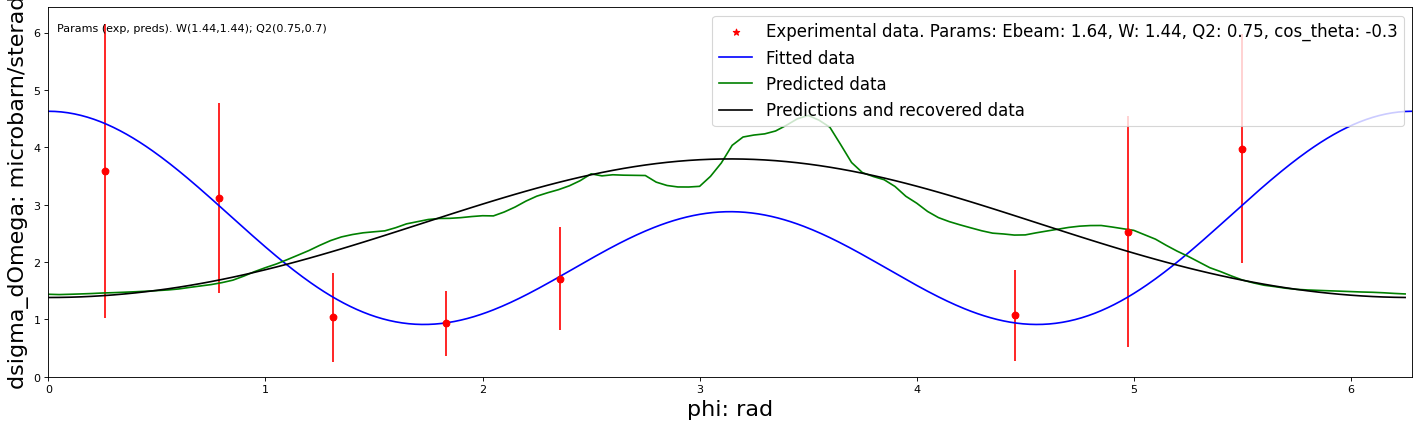

2024-12-03 16:02:52,649 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,651 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:52,653 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:52,655 : DEBUG : STREAM b'IDAT' 131 36433
2024-12-03 16:02:52,787 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:52,790 : DEBUG : STREAM b'IDAT' 41 36433


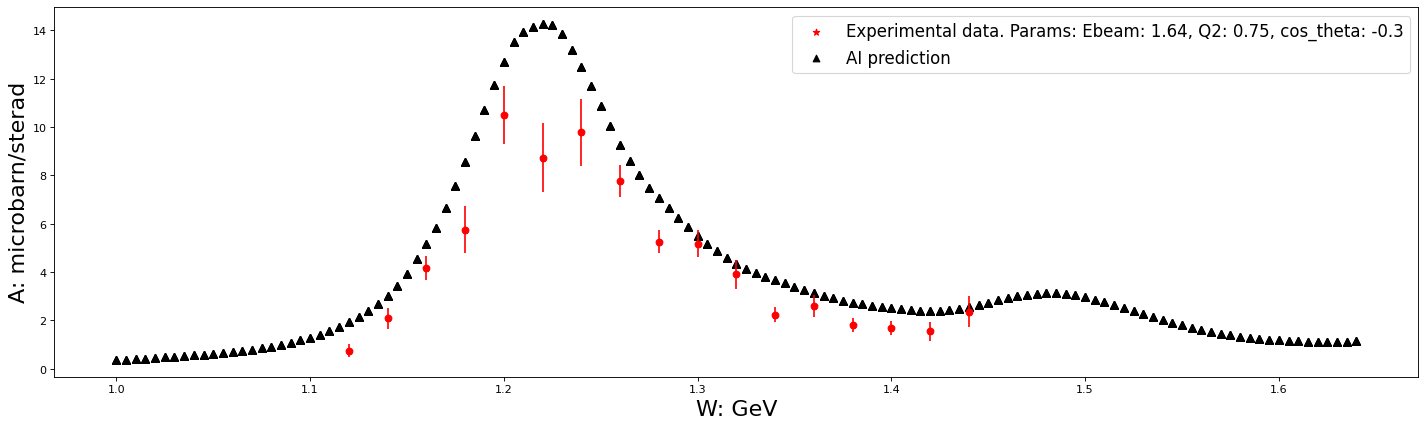

2024-12-03 16:02:53,850 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,852 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:53,854 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:53,856 : DEBUG : STREAM b'IDAT' 131 35982
2024-12-03 16:02:53,938 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:53,940 : DEBUG : STREAM b'IDAT' 41 35982


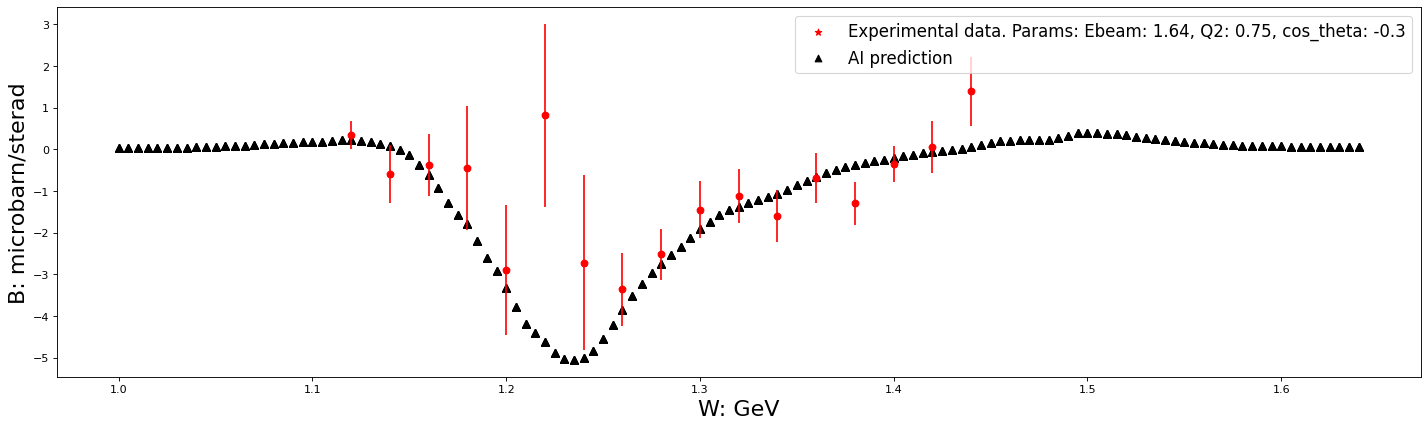

2024-12-03 16:02:54,613 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,615 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:54,617 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:54,620 : DEBUG : STREAM b'IDAT' 131 36865
2024-12-03 16:02:54,704 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:54,706 : DEBUG : STREAM b'IDAT' 41 36865


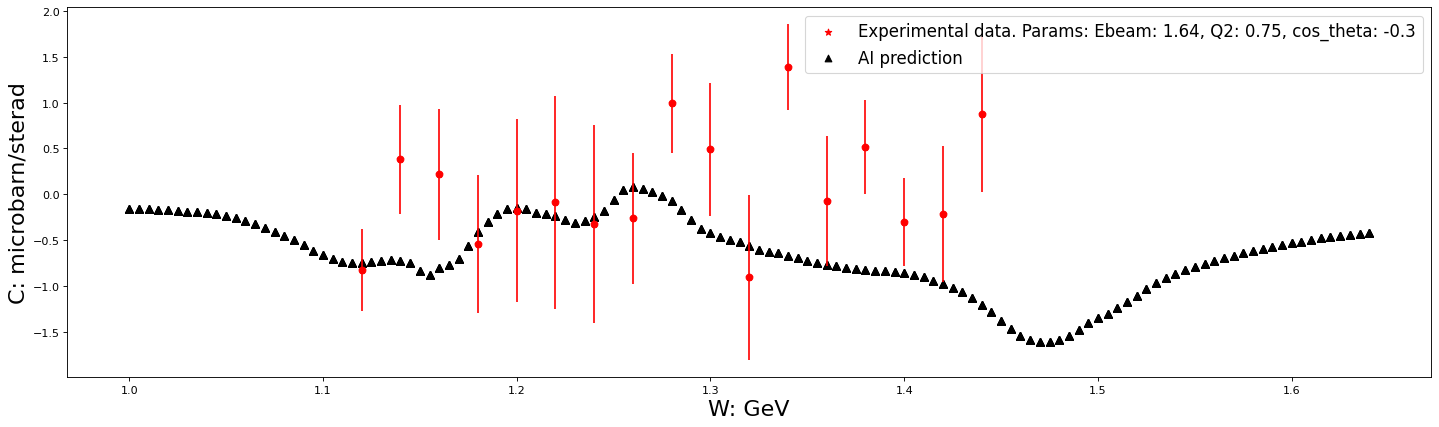

1
2024-12-03 16:02:55,385 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,387 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:55,390 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:55,394 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:02:55,485 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:55,488 : DEBUG : STREAM b'IDAT' 41 65536


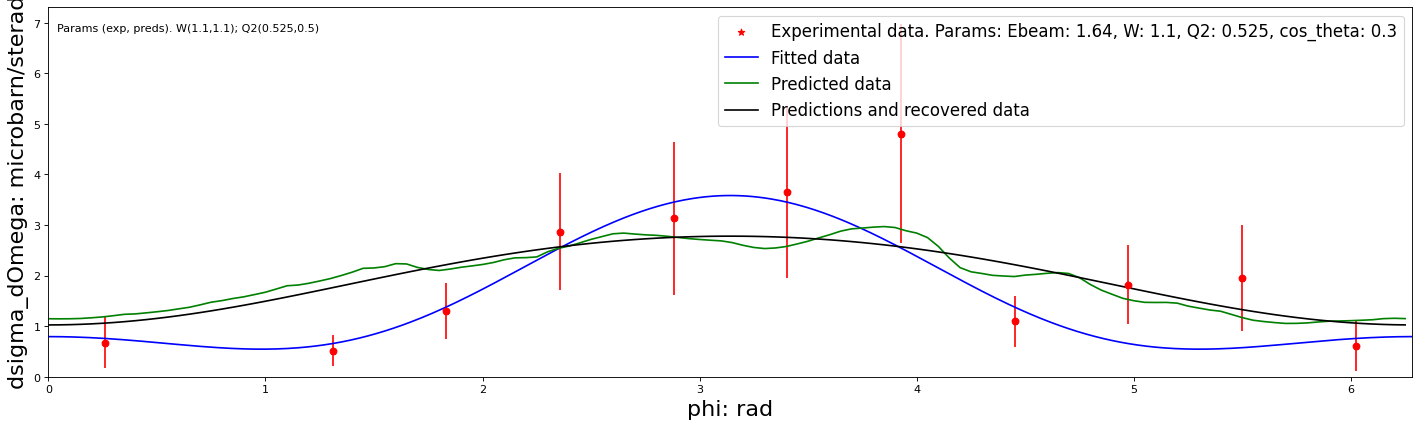

2024-12-03 16:02:56,183 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,185 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:56,191 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:56,195 : DEBUG : STREAM b'IDAT' 131 37516
2024-12-03 16:02:56,292 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,295 : DEBUG : STREAM b'IDAT' 41 37516


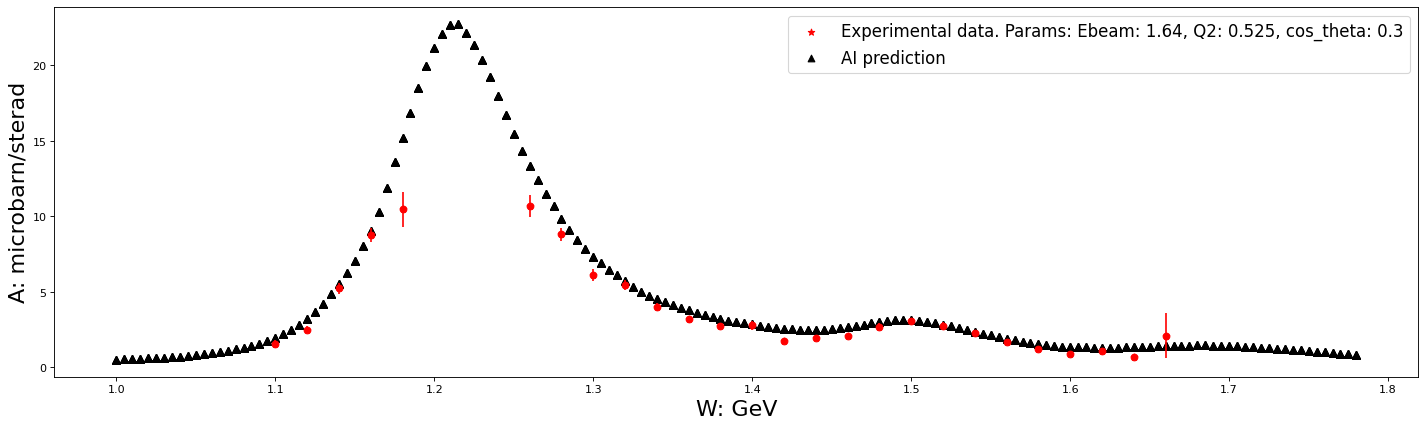

2024-12-03 16:02:56,996 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:56,998 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,000 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,002 : DEBUG : STREAM b'IDAT' 131 36214
2024-12-03 16:02:57,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,086 : DEBUG : STREAM b'IDAT' 41 36214


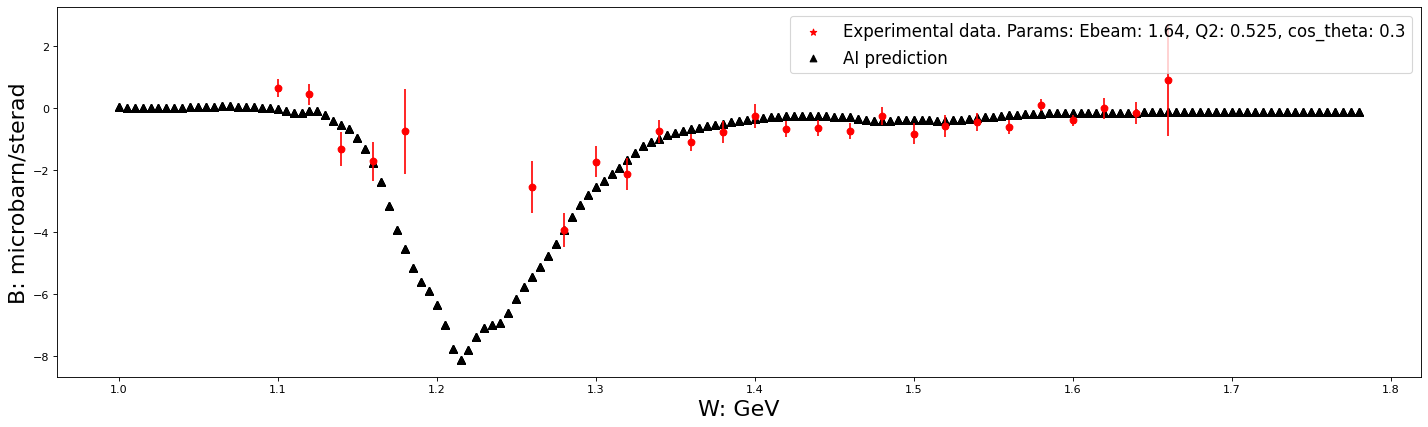

2024-12-03 16:02:57,790 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,792 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:02:57,795 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:02:57,798 : DEBUG : STREAM b'IDAT' 131 36991
2024-12-03 16:02:57,884 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:02:57,886 : DEBUG : STREAM b'IDAT' 41 36991


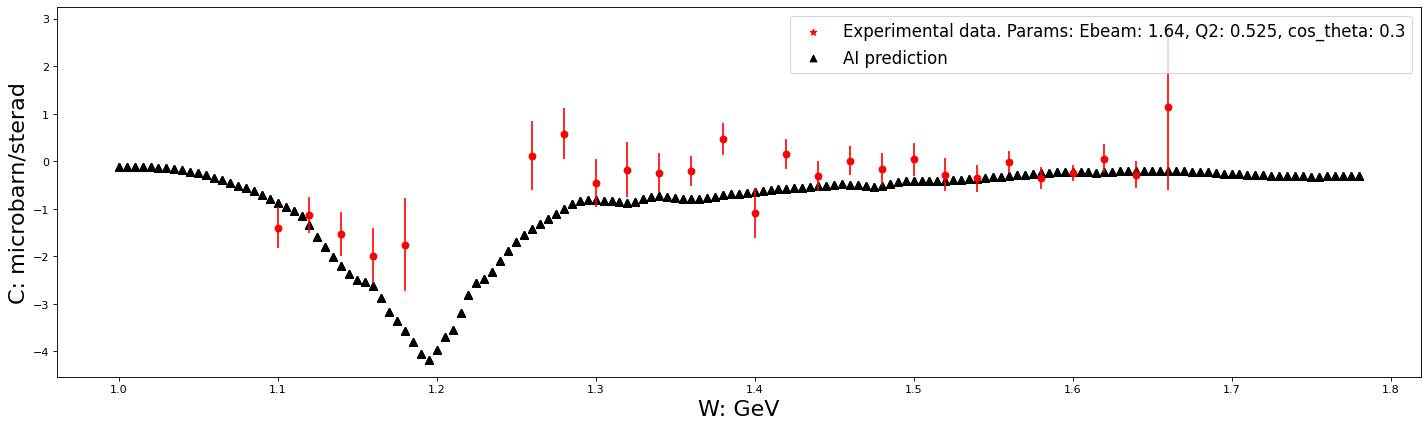

2


100%|██████████| 157/157 [00:07<00:00, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-7-2de690fa5e0e>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3759944385466103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-7-2de690fa5e0e>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06444017856602151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-

2024-12-03 16:17:39,521 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,522 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:39,525 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:39,528 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:39,644 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:39,647 : DEBUG : STREAM b'IDAT' 41 65536


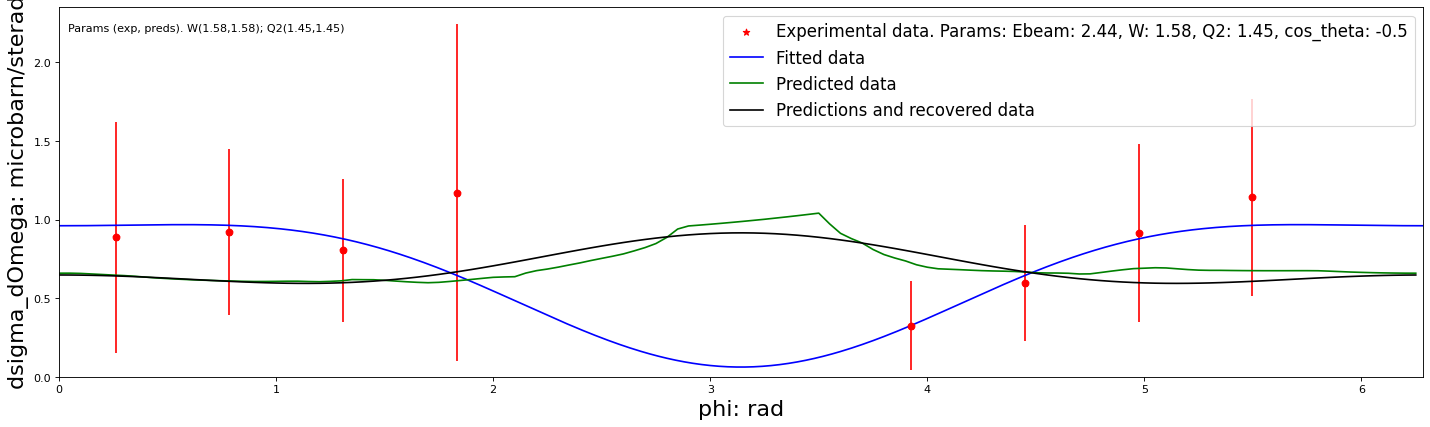

2024-12-03 16:17:40,530 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,533 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:40,535 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:40,537 : DEBUG : STREAM b'IDAT' 131 39649
2024-12-03 16:17:40,633 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:40,636 : DEBUG : STREAM b'IDAT' 41 39649


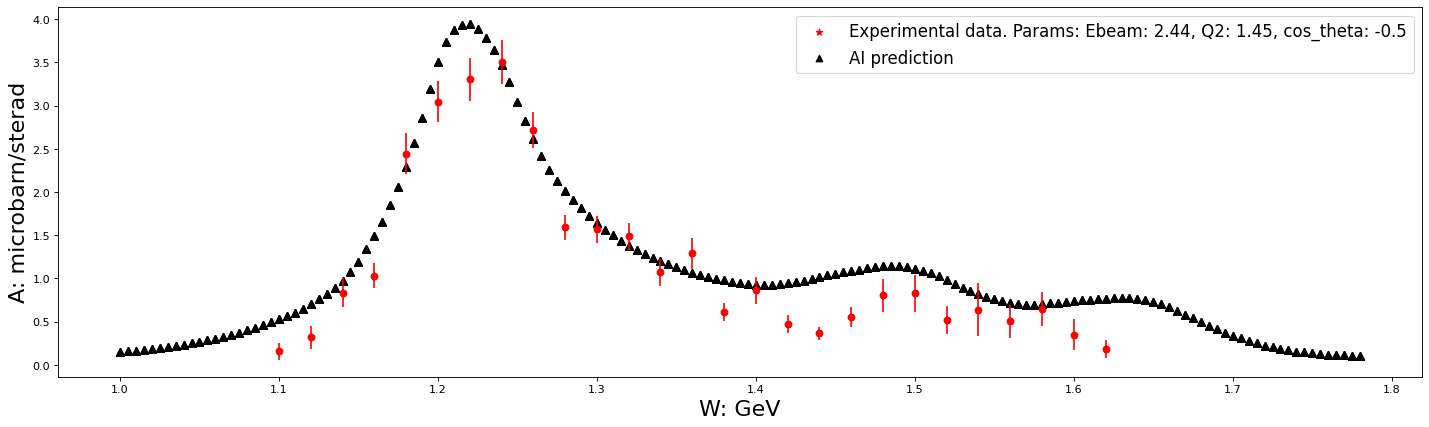

2024-12-03 16:17:41,532 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,534 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:41,537 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:41,539 : DEBUG : STREAM b'IDAT' 131 39774
2024-12-03 16:17:41,635 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:41,641 : DEBUG : STREAM b'IDAT' 41 39774


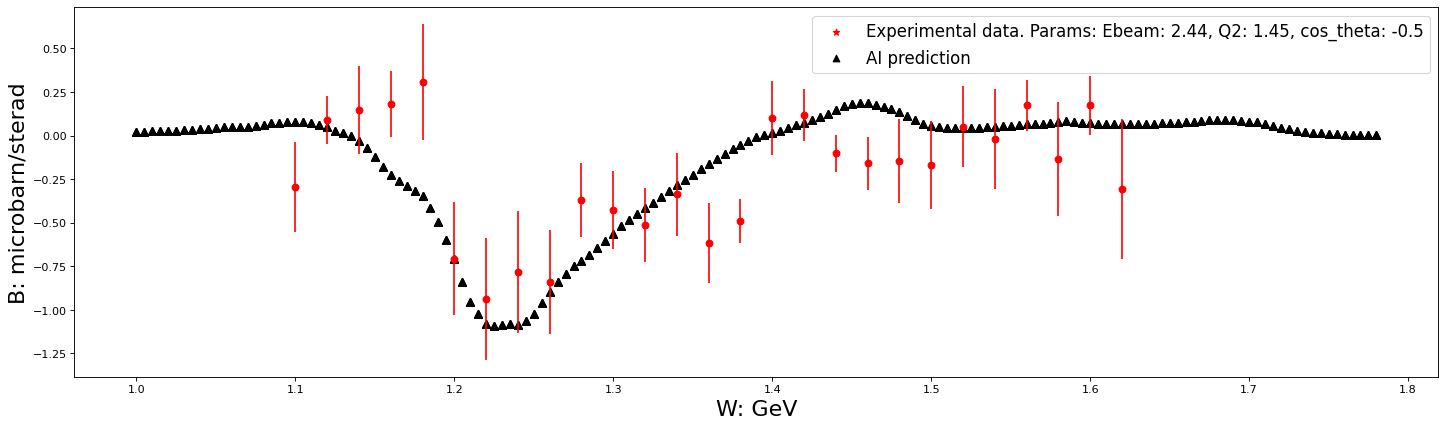

2024-12-03 16:17:42,570 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,574 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:42,576 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:42,579 : DEBUG : STREAM b'IDAT' 131 40327
2024-12-03 16:17:42,675 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:42,677 : DEBUG : STREAM b'IDAT' 41 40327


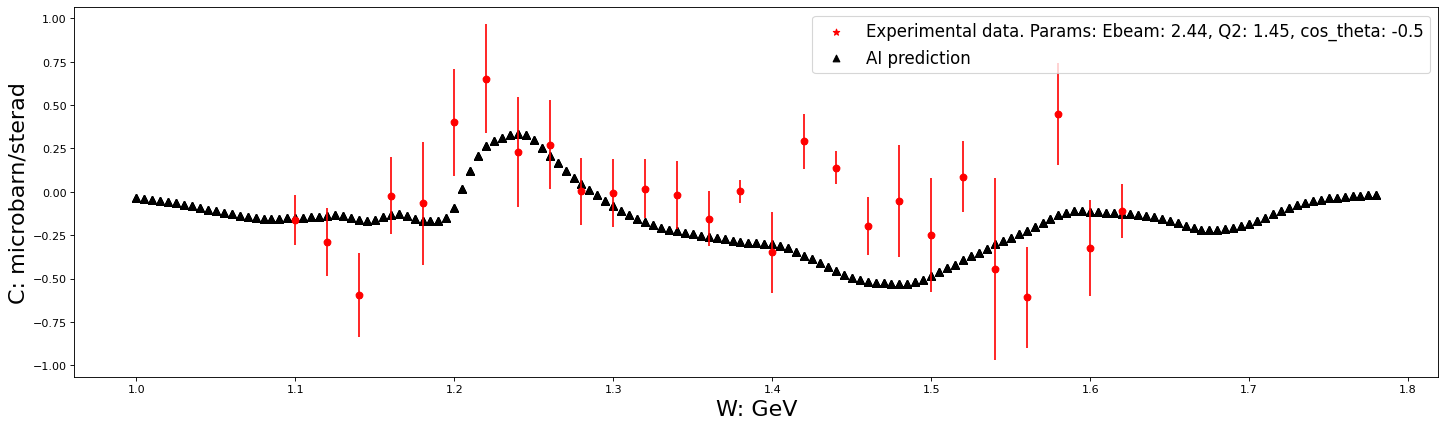

1
2024-12-03 16:17:43,580 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,582 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:43,585 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:43,588 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-03 16:17:43,687 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:43,692 : DEBUG : STREAM b'IDAT' 41 65536


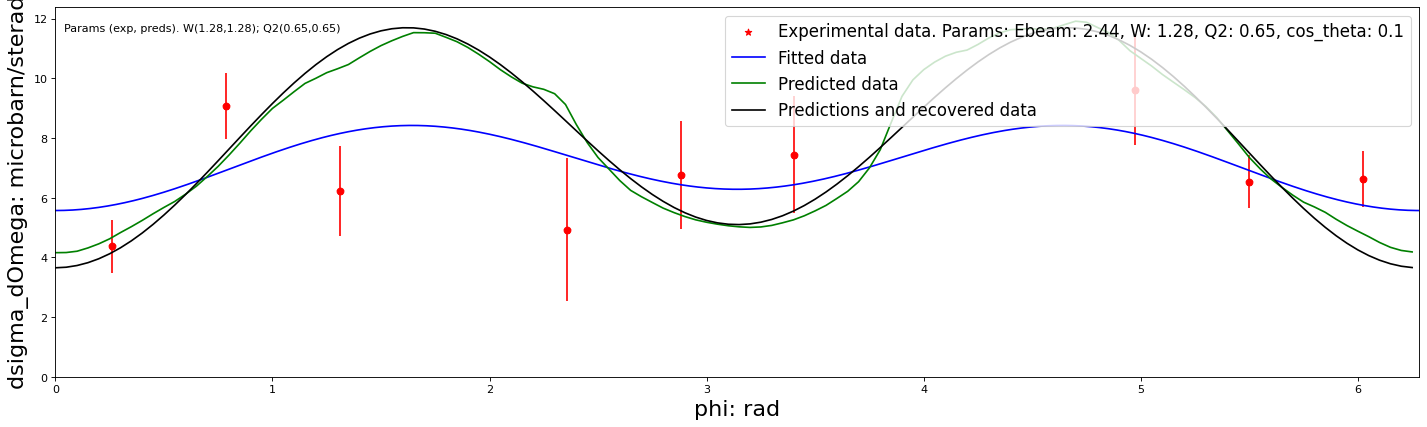

2024-12-03 16:17:44,586 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,589 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:44,591 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:44,594 : DEBUG : STREAM b'IDAT' 131 39500
2024-12-03 16:17:44,691 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:44,693 : DEBUG : STREAM b'IDAT' 41 39500


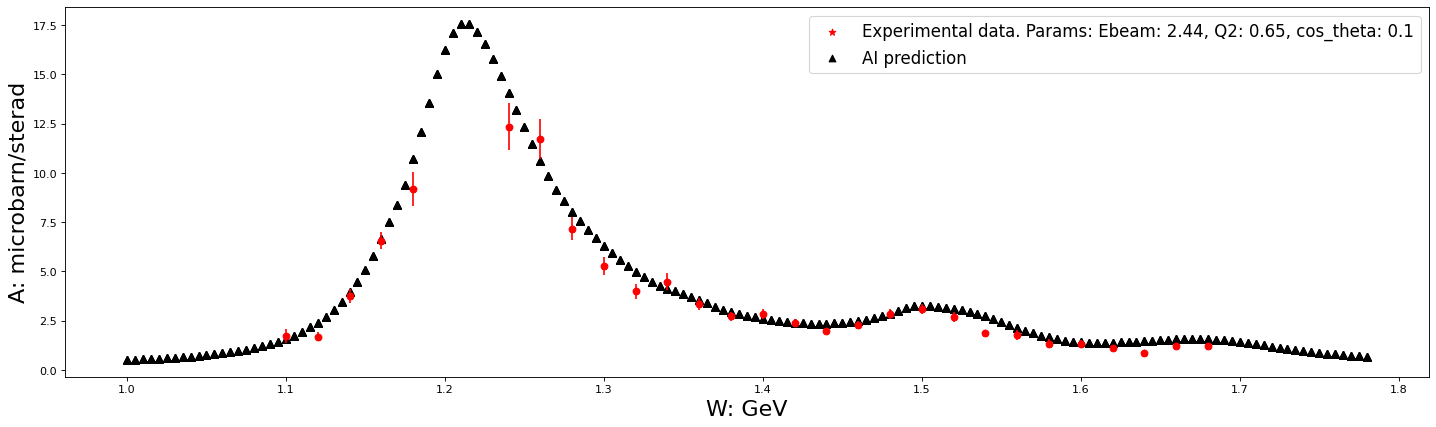

2024-12-03 16:17:45,591 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,593 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:45,596 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:45,599 : DEBUG : STREAM b'IDAT' 131 36530
2024-12-03 16:17:45,692 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:45,694 : DEBUG : STREAM b'IDAT' 41 36530


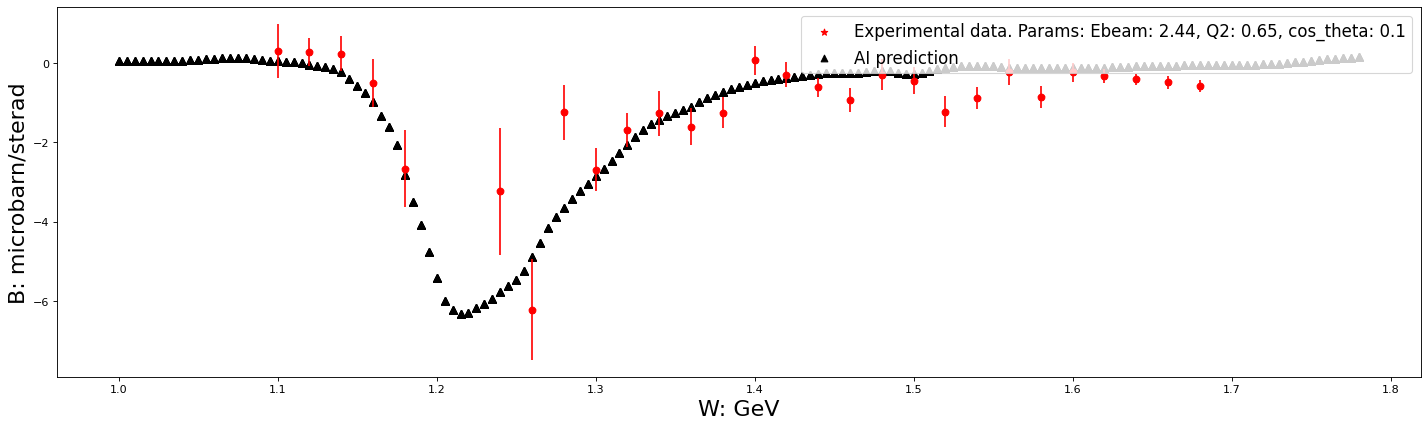

2024-12-03 16:17:46,823 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,828 : DEBUG : STREAM b'tEXt' 41 57
2024-12-03 16:17:46,830 : DEBUG : STREAM b'pHYs' 110 9
2024-12-03 16:17:46,833 : DEBUG : STREAM b'IDAT' 131 39694
2024-12-03 16:17:46,983 : DEBUG : STREAM b'IHDR' 16 13
2024-12-03 16:17:46,988 : DEBUG : STREAM b'IDAT' 41 39694


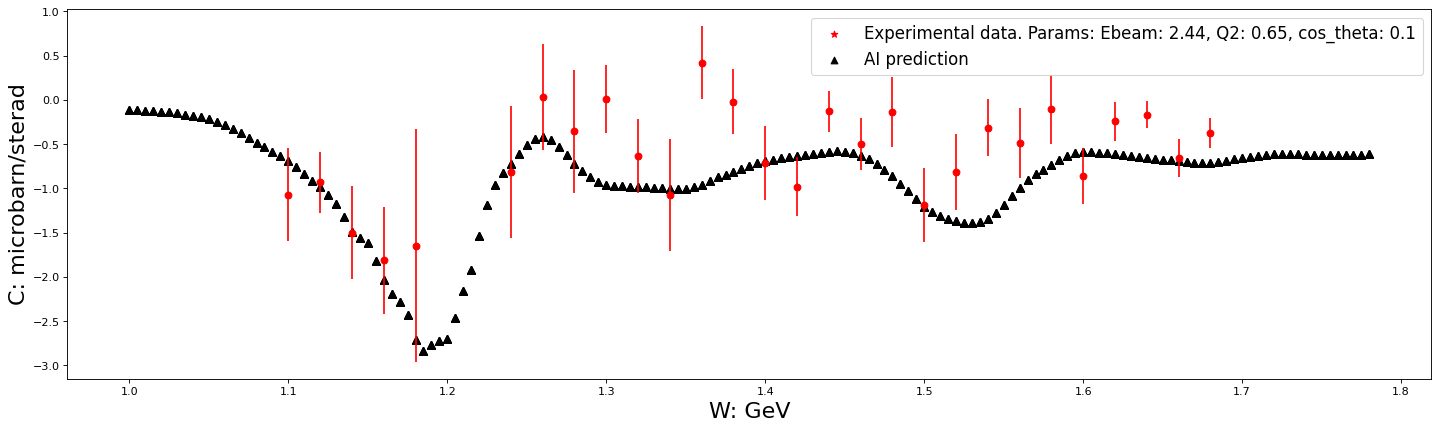

2


100%|██████████| 97/97 [00:09<00:00, 10.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
 24%|██▍       | 24/100 [04:08<13:07, 10.36s/it]


KeyboardInterrupt: 

In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False